In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
from sklearn.decomposition import PCA
from tqdm import tqdm
from numpy import linalg as LA
from scipy import spatial
import pickle

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_start = 1
pred_end = 2

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()[:, pred_start:pred_end]
pro_s1d2 = pro_s1d2.X.toarray()[:, pred_start:pred_end]
pro_s1d3 = pro_s1d3.X.toarray()[:, pred_start:pred_end]
pro_s2d1 = pro_s2d1.X.toarray()[:, pred_start:pred_end]
pro_s2d4 = pro_s2d4.X.toarray()[:, pred_start:pred_end]
pro_s2d5 = pro_s2d5.X.toarray()[:, pred_start:pred_end]

pro_s3d1 = pro_s3d1.X.toarray()[:, pred_start:pred_end]
pro_s3d6 = pro_s3d6.X.toarray()[:, pred_start:pred_end]
pro_s3d7 = pro_s3d7.X.toarray()[:, pred_start:pred_end]

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()[:, pred_start:pred_end]
pro_s4d8 = pro_s4d8.X.toarray()[:, pred_start:pred_end]
pro_s4d9 = pro_s4d9.X.toarray()[:, pred_start:pred_end]

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 1)


In [17]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [18]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [19]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [20]:
train_input = train_input + val_input
train_output = train_output + val_output

In [21]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [22]:
RNA_s1d1 = torch.from_numpy(RNA_s1d1)
RNA_s1d2 = torch.from_numpy(RNA_s1d2)
RNA_s1d3 = torch.from_numpy(RNA_s1d3)
RNA_s2d1 = torch.from_numpy(RNA_s2d1)
RNA_s2d4 = torch.from_numpy(RNA_s2d4)
RNA_s2d5 = torch.from_numpy(RNA_s2d5)
RNA_s3d1 = torch.from_numpy(RNA_s3d1)
RNA_s3d6 = torch.from_numpy(RNA_s3d6)
RNA_s3d7 = torch.from_numpy(RNA_s3d7)
RNA_s4d1 = torch.from_numpy(RNA_s4d1)
RNA_s4d8 = torch.from_numpy(RNA_s4d8)
RNA_s4d9 = torch.from_numpy(RNA_s4d9)

In [23]:
pro_s1d1 = torch.from_numpy(pro_s1d1)
pro_s1d2 = torch.from_numpy(pro_s1d2)
pro_s1d3 = torch.from_numpy(pro_s1d3)
pro_s2d1 = torch.from_numpy(pro_s2d1)
pro_s2d4 = torch.from_numpy(pro_s2d4)
pro_s2d5 = torch.from_numpy(pro_s2d5)
pro_s3d1 = torch.from_numpy(pro_s3d1)
pro_s3d6 = torch.from_numpy(pro_s3d6)
pro_s3d7 = torch.from_numpy(pro_s3d7)
pro_s4d1 = torch.from_numpy(pro_s4d1)
pro_s4d8 = torch.from_numpy(pro_s4d8)
pro_s4d9 = torch.from_numpy(pro_s4d9)

In [24]:
train_input = torch.from_numpy(train_input)
val_input = torch.from_numpy(val_input)
test_input = torch.from_numpy(test_input)

train_output = torch.from_numpy(train_output)
val_output = torch.from_numpy(val_output)
test_output = torch.from_numpy(test_output)

In [25]:
print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

print(train_output.shape)
print(val_output.shape)
print(test_output.shape)

torch.Size([66175, 13953])
torch.Size([28921, 13953])
torch.Size([1000, 13953])
torch.Size([66175, 1])
torch.Size([28921, 1])
torch.Size([1000, 1])


In [26]:
def top_samples(source, target, num):
    temp_list = []
    for i in range(target.shape[0]):
        temp_list.append([spatial.distance.cosine(source, target[i]), i])
    temp_list.sort()
    return [ele[1] for ele in temp_list[:num]]

In [27]:
nn_num = 5

In [28]:
input_near_ind_list = []
output_near_ind_list = []

for i in tqdm(range(RNA_s4d9.shape[0])):
    near_neig_ind = top_samples(RNA_s4d9[i], RNA_s3d1, nn_num)
    input_near_ind_list.append(RNA_s3d1[near_neig_ind])
    output_near_ind_list.append(pro_s3d1[near_neig_ind])
    
input_near = np.concatenate(input_near_ind_list, axis= 0)
output_near = np.concatenate(output_near_ind_list, axis= 0)

100%|██████████| 459/459 [14:08<00:00,  1.85s/it]


In [29]:
# with open(r"input_near_cos.pickle", "wb") as output_file:
#     pickle.dump(input_near, output_file)
    
# with open(r"output_near_cos.pickle", "wb") as output_file:
#     pickle.dump(output_near, output_file)

In [30]:
# with open(r"input_near_cos.pickle", "rb") as input_file:
#     input_near = pickle.load(input_file)
    
# with open(r"output_near_cos.pickle", "rb") as input_file:
#     output_near = pickle.load(input_file)

In [31]:
RNA_s1d1 = RNA_s1d1.float()
RNA_s1d2 = RNA_s1d2.float()
RNA_s1d3 = RNA_s1d3.float()
RNA_s2d1 = RNA_s2d1.float()
RNA_s2d4 = RNA_s2d4.float()
RNA_s2d5 = RNA_s2d5.float()
RNA_s3d1 = RNA_s3d1.float()
RNA_s3d6 = RNA_s3d6.float()
RNA_s3d7 = RNA_s3d7.float()
RNA_s4d1 = RNA_s4d1.float()
RNA_s4d8 = RNA_s4d8.float()
RNA_s4d9 = RNA_s4d9.float()

pro_s1d1 = pro_s1d1.float()
pro_s1d2 = pro_s1d2.float()
pro_s1d3 = pro_s1d3.float()
pro_s2d1 = pro_s2d1.float()
pro_s2d4 = pro_s2d4.float()
pro_s2d5 = pro_s2d5.float()
pro_s3d1 = pro_s3d1.float()
pro_s3d6 = pro_s3d6.float()
pro_s3d7 = pro_s3d7.float()
pro_s4d1 = pro_s4d1.float()
pro_s4d8 = pro_s4d8.float()
pro_s4d9 = pro_s4d9.float()

In [32]:
train_input = train_input.float()
val_input = val_input.float()
test_input = test_input.float()

train_output = train_output.float()
val_output = val_output.float()
test_output = test_output.float()

In [33]:
RNA_s1d1 = RNA_s1d1.to(device)
RNA_s1d2 = RNA_s1d2.to(device)
RNA_s1d3 = RNA_s1d3.to(device)
RNA_s2d1 = RNA_s2d1.to(device)
RNA_s2d4 = RNA_s2d4.to(device)
RNA_s2d5 = RNA_s2d5.to(device)
RNA_s3d1 = RNA_s3d1.to(device)
RNA_s3d6 = RNA_s3d6.to(device)
RNA_s3d7 = RNA_s3d7.to(device)
RNA_s4d1 = RNA_s4d1.to(device)
RNA_s4d8 = RNA_s4d8.to(device)
RNA_s4d9 = RNA_s4d9.to(device)

pro_s1d1 = pro_s1d1.to(device)
pro_s1d2 = pro_s1d2.to(device)
pro_s1d3 = pro_s1d3.to(device)
pro_s2d1 = pro_s2d1.to(device)
pro_s2d4 = pro_s2d4.to(device)
pro_s2d5 = pro_s2d5.to(device)
pro_s3d1 = pro_s3d1.to(device)
pro_s3d6 = pro_s3d6.to(device)
pro_s3d7 = pro_s3d7.to(device)
pro_s4d1 = pro_s4d1.to(device)
pro_s4d8 = pro_s4d8.to(device)
pro_s4d9 = pro_s4d9.to(device)

In [34]:
train_input = train_input.to(device)
val_input = val_input.to(device)
test_input = test_input.to(device)

train_output = train_output.to(device)
val_output = val_output.to(device)
test_output = test_output.to(device)

In [35]:
input_near = torch.from_numpy(input_near)
output_near = torch.from_numpy(output_near)

In [36]:
input_near = input_near.to(device)
output_near = output_near.to(device)

In [37]:
input_feature = RNA_s1d1.shape[1]

In [38]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, 1)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [39]:
PATH = 'No_norm_model_RNA_pro'

In [40]:
def fit(num_epochs, model, loss_fn, RNA, pro):
    train_ds = TensorDataset(RNA, pro)
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            near_pred = model(input_near)
            near_loss = loss_fn(near_pred, output_near)
            near_loss = torch.sqrt(near_loss)
            near_loss = near_loss.cpu().detach().numpy()
            
            s1d1_pred = model(RNA_s1d1)
            s1d1_loss = loss_fn(s1d1_pred, pro_s1d1)
            s1d1_loss = torch.sqrt(s1d1_loss)
            s1d1_loss = s1d1_loss.cpu().detach().numpy()
            
            s1d2_pred = model(RNA_s1d2)
            s1d2_loss = loss_fn(s1d2_pred, pro_s1d2)
            s1d2_loss = torch.sqrt(s1d2_loss)
            s1d2_loss = s1d2_loss.cpu().detach().numpy()
            
            s1d3_pred = model(RNA_s1d3)
            s1d3_loss = loss_fn(s1d3_pred, pro_s1d3)
            s1d3_loss = torch.sqrt(s1d3_loss)
            s1d3_loss = s1d3_loss.cpu().detach().numpy()
            
            s2d1_pred = model(RNA_s2d1)
            s2d1_loss = loss_fn(s2d1_pred, pro_s2d1)
            s2d1_loss = torch.sqrt(s2d1_loss)
            s2d1_loss = s2d1_loss.cpu().detach().numpy()
            
            s2d4_pred = model(RNA_s2d4)
            s2d4_loss = loss_fn(s2d4_pred, pro_s2d4)
            s2d4_loss = torch.sqrt(s2d4_loss)
            s2d4_loss = s2d4_loss.cpu().detach().numpy()
            
            s2d5_pred = model(RNA_s2d5)
            s2d5_loss = loss_fn(s2d5_pred, pro_s2d5)
            s2d5_loss = torch.sqrt(s2d5_loss)
            s2d5_loss = s2d5_loss.cpu().detach().numpy()
            
            s3d1_pred = model(RNA_s3d1)
            s3d1_loss = loss_fn(s3d1_pred, pro_s3d1)
            s3d1_loss = torch.sqrt(s3d1_loss)
            s3d1_loss = s3d1_loss.cpu().detach().numpy()
            
            s3d6_pred = model(RNA_s3d6)
            s3d6_loss = loss_fn(s3d6_pred, pro_s3d6)
            s3d6_loss = torch.sqrt(s3d6_loss)
            s3d6_loss = s3d6_loss.cpu().detach().numpy()
            
            s3d7_pred = model(RNA_s3d7)
            s3d7_loss = loss_fn(s3d7_pred, pro_s3d7)
            s3d7_loss = torch.sqrt(s3d7_loss)
            s3d7_loss = s3d7_loss.cpu().detach().numpy()

            s4d1_pred = model(RNA_s4d1)
            s4d1_loss = loss_fn(s4d1_pred, pro_s4d1)
            s4d1_loss = torch.sqrt(s4d1_loss)
            s4d1_loss = s4d1_loss.cpu().detach().numpy()
            
            s4d8_pred = model(RNA_s4d8)
            s4d8_loss = loss_fn(s4d8_pred, pro_s4d8)
            s4d8_loss = torch.sqrt(s4d8_loss)
            s4d8_loss = s4d8_loss.cpu().detach().numpy()
            
            s4d9_pred = model(RNA_s4d9)
            s4d9_loss = loss_fn(s4d9_pred, pro_s4d9)
            s4d9_loss = torch.sqrt(s4d9_loss)
            s4d9_loss = s4d9_loss.cpu().detach().numpy()
            
            test_loss = ((s4d1_loss**2*s4d1_pred.shape[0] + s4d8_loss**2*s4d8_pred.shape[0] + s4d9_loss**2*s4d9_pred.shape[0])/(s4d1_pred.shape[0]+s4d8_pred.shape[0]+s4d9_pred.shape[0]))**0.5
            
            print('Epoch ', epoch, 'near loss:', near_loss, 's1d1: ', s1d1_loss, 's1d2: ', s1d2_loss, 's1d3: ', s1d3_loss, 's2d1:', s2d1_loss, 's2d4:',
                  s2d4_loss, 's2d5:', s2d5_loss, 's3d1:', s3d1_loss, 's3d6:', s3d6_loss, 's3d7:', s3d7_loss, 's4d1:', s4d1_loss, 's4d8:', s4d8_loss, 's4d9:', s4d9_loss, 'test loss:', test_loss)
            
        if epoch % 1000 == 0:
            figure, ax = plt.subplots(1, 13, figsize = (33, 3))
            for i in range(1):
                
                ax[0].scatter(output_near.cpu().detach().numpy()[:, 0], near_pred.cpu().detach().numpy()[:, 0], c='purple', s = 30, alpha=0.05)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Nearest neighbor result')
                ax[0].set_xlabel('true')
                ax[0].set_ylabel('pred')
                
                ax[1].scatter(pro_s1d1.cpu().detach().numpy()[:, 0], s1d1_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('s1d1 result')
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(pro_s1d2.cpu().detach().numpy()[:, 0], s1d2_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('s1d2 result')
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')

                ax[3].scatter(pro_s1d3.cpu().detach().numpy()[:, 0], s1d3_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[3].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[3].set_title('s1d3 result')
                ax[3].set_xlabel('true')
                ax[3].set_ylabel('pred')
                
                ax[4].scatter(pro_s2d1.cpu().detach().numpy()[:, 0], s2d1_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[4].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[4].set_title('s2d1 result')
                ax[4].set_xlabel('true')
                ax[4].set_ylabel('pred')

                ax[5].scatter(pro_s2d4.cpu().detach().numpy()[:, 0], s2d4_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[5].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[5].set_title('s2d4 result')
                ax[5].set_xlabel('true')
                ax[5].set_ylabel('pred')

                ax[6].scatter(pro_s2d5.cpu().detach().numpy()[:, 0], s2d5_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[6].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[6].set_title('s2d5 result')
                ax[6].set_xlabel('true')
                ax[6].set_ylabel('pred')
                
                ax[7].scatter(pro_s3d1.cpu().detach().numpy()[:, 0], s3d1_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[7].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[7].set_title('s3d1 result')
                ax[7].set_xlabel('true')
                ax[7].set_ylabel('pred')

                ax[8].scatter(pro_s3d6.cpu().detach().numpy()[:, 0], s3d6_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[8].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[8].set_title('s3d6 result')
                ax[8].set_xlabel('true')
                ax[8].set_ylabel('pred')

                ax[9].scatter(pro_s3d7.cpu().detach().numpy()[:, 0], s3d7_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[9].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[9].set_title('s3d7 result')
                ax[9].set_xlabel('true')
                ax[9].set_ylabel('pred')
                
                ax[10].scatter(pro_s4d1.cpu().detach().numpy()[:, 0], s4d1_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[10].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[10].set_title('s4d1 result')
                ax[10].set_xlabel('true')
                ax[10].set_ylabel('pred')

                ax[11].scatter(pro_s4d8.cpu().detach().numpy()[:, 0], s4d8_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[11].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[11].set_title('s4d8 result')
                ax[11].set_xlabel('true')
                ax[11].set_ylabel('pred')

                ax[12].scatter(pro_s4d9.cpu().detach().numpy()[:, 0], s4d9_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[12].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[12].set_title('s4d9 result')
                ax[12].set_xlabel('true')
                ax[12].set_ylabel('pred')
            
            plt.show()
    return

Epoch  0 near loss: 0.34527847 s1d1:  1.0624976 s1d2:  1.148723 s1d3:  1.0041032 s2d1: 0.56808877 s2d4: 0.6699275 s2d5: 0.71025395 s3d1: 0.2856795 s3d6: 0.71570987 s3d7: 0.84506124 s4d1: 0.847392 s4d8: 1.076837 s4d9: 0.4807176 test loss: 0.7654666027950797


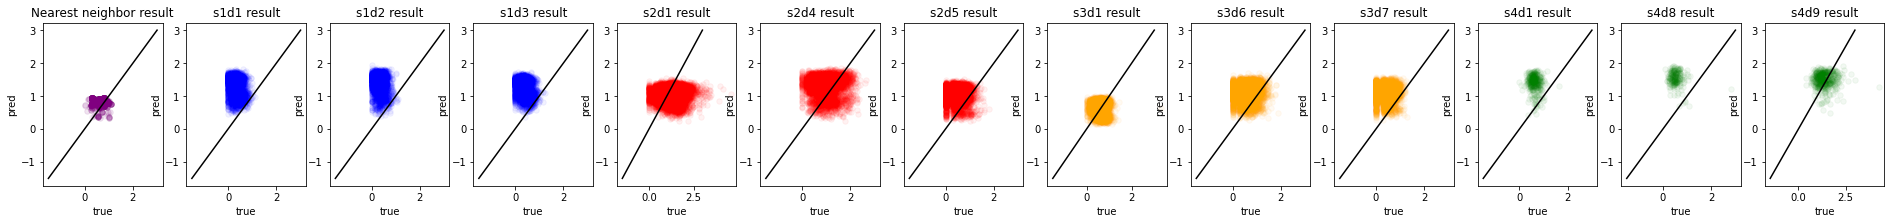

Epoch  100 near loss: 0.070327565 s1d1:  0.6531353 s1d2:  0.65000075 s1d3:  0.5945594 s2d1: 0.6998316 s2d4: 0.46434614 s2d5: 0.39018008 s3d1: 0.2042097 s3d6: 0.40801138 s3d7: 0.45655373 s4d1: 0.3951827 s4d8: 0.5874437 s4d9: 0.5340972 test loss: 0.5045081553071745
Epoch  200 near loss: 0.039108578 s1d1:  0.66708344 s1d2:  0.65601206 s1d3:  0.6048283 s2d1: 0.6912113 s2d4: 0.4661752 s2d5: 0.401244 s3d1: 0.20297517 s3d6: 0.41985014 s3d7: 0.47191355 s4d1: 0.40761745 s4d8: 0.59856737 s4d9: 0.5246272 test loss: 0.505956122348413
Epoch  300 near loss: 0.026119852 s1d1:  0.669832 s1d2:  0.6528056 s1d3:  0.6102721 s2d1: 0.68609434 s2d4: 0.46711168 s2d5: 0.40468407 s3d1: 0.20247851 s3d6: 0.4255773 s3d7: 0.4792015 s4d1: 0.4073784 s4d8: 0.59686667 s4d9: 0.5232422 test loss: 0.5048163166048277
Epoch  400 near loss: 0.018915059 s1d1:  0.66767156 s1d2:  0.64880085 s1d3:  0.61014915 s2d1: 0.683641 s2d4: 0.46715638 s2d5: 0.40612152 s3d1: 0.20213574 s3d6: 0.42773333 s3d7: 0.48341575 s4d1: 0.40454105 s4d8

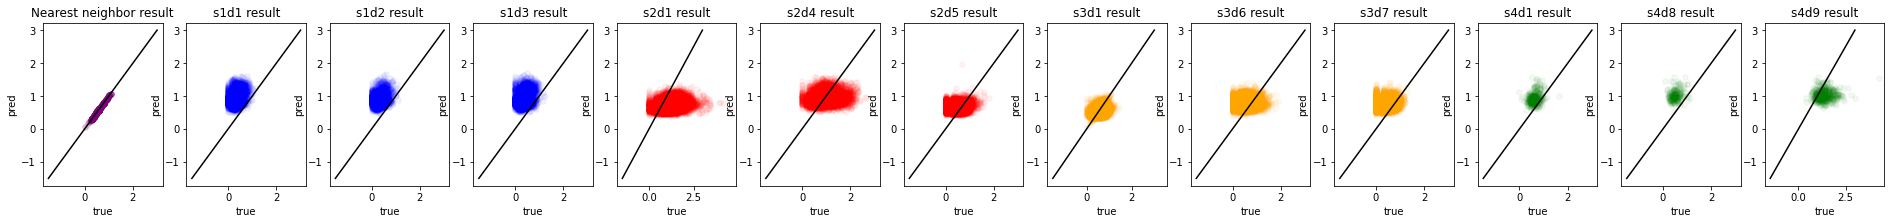

Epoch  1100 near loss: 0.004834093 s1d1:  0.64534926 s1d2:  0.62107986 s1d3:  0.5913515 s2d1: 0.68340534 s2d4: 0.46496564 s2d5: 0.4032842 s3d1: 0.20120075 s3d6: 0.4240937 s3d7: 0.48368692 s4d1: 0.3808148 s4d8: 0.56839204 s4d9: 0.53500414 test loss: 0.4966803259026028
Epoch  1200 near loss: 0.004401671 s1d1:  0.6427453 s1d2:  0.6176306 s1d3:  0.5886974 s2d1: 0.6841675 s2d4: 0.46480617 s2d5: 0.4021438 s3d1: 0.20112248 s3d6: 0.4228935 s3d7: 0.48231846 s4d1: 0.37797618 s4d8: 0.5647981 s4d9: 0.5369613 test loss: 0.4960765070884784
Epoch  1300 near loss: 0.003938003 s1d1:  0.6395067 s1d2:  0.61328757 s1d3:  0.58598155 s2d1: 0.68478113 s2d4: 0.46467322 s2d5: 0.40113807 s3d1: 0.20113426 s3d6: 0.42176986 s3d7: 0.4805139 s4d1: 0.37487292 s4d8: 0.56067806 s4d9: 0.53900063 test loss: 0.4953371315315954
Epoch  1400 near loss: 0.0036031783 s1d1:  0.635725 s1d2:  0.6090713 s1d3:  0.5827084 s2d1: 0.68595904 s2d4: 0.46451178 s2d5: 0.39999747 s3d1: 0.20107825 s3d6: 0.42030364 s3d7: 0.47854352 s4d1: 0.37

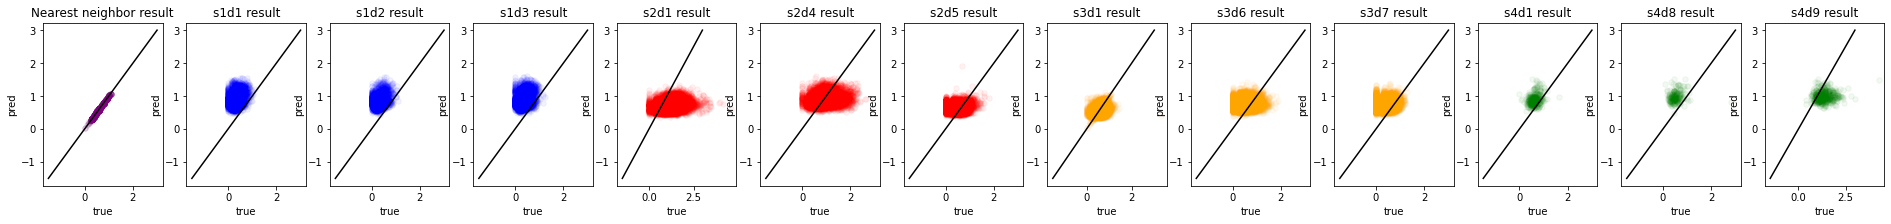

Epoch  2100 near loss: 0.0023722202 s1d1:  0.6119429 s1d2:  0.5828118 s1d3:  0.56196105 s2d1: 0.6929404 s2d4: 0.46457544 s2d5: 0.39270288 s3d1: 0.20076083 s3d6: 0.4117137 s3d7: 0.4658057 s4d1: 0.34931576 s4d8: 0.52996016 s4d9: 0.55709964 test loss: 0.4912718062408237
Epoch  2200 near loss: 0.002290489 s1d1:  0.6098808 s1d2:  0.58006954 s1d3:  0.5599944 s2d1: 0.6936169 s2d4: 0.46474206 s2d5: 0.3917236 s3d1: 0.20084147 s3d6: 0.4108533 s3d7: 0.4645643 s4d1: 0.3468514 s4d8: 0.5267591 s4d9: 0.55919313 test loss: 0.49106764674866965
Epoch  2300 near loss: 0.002176039 s1d1:  0.6055233 s1d2:  0.5762855 s1d3:  0.5557954 s2d1: 0.6950068 s2d4: 0.46480346 s2d5: 0.39076033 s3d1: 0.20065193 s3d6: 0.4094396 s3d7: 0.4626403 s4d1: 0.34332782 s4d8: 0.5230587 s4d9: 0.5616919 test loss: 0.49073067807145865
Epoch  2400 near loss: 0.0021797908 s1d1:  0.6038285 s1d2:  0.57378536 s1d3:  0.55438405 s2d1: 0.6958076 s2d4: 0.46492594 s2d5: 0.38978282 s3d1: 0.2007273 s3d6: 0.4085739 s3d7: 0.46135753 s4d1: 0.341503

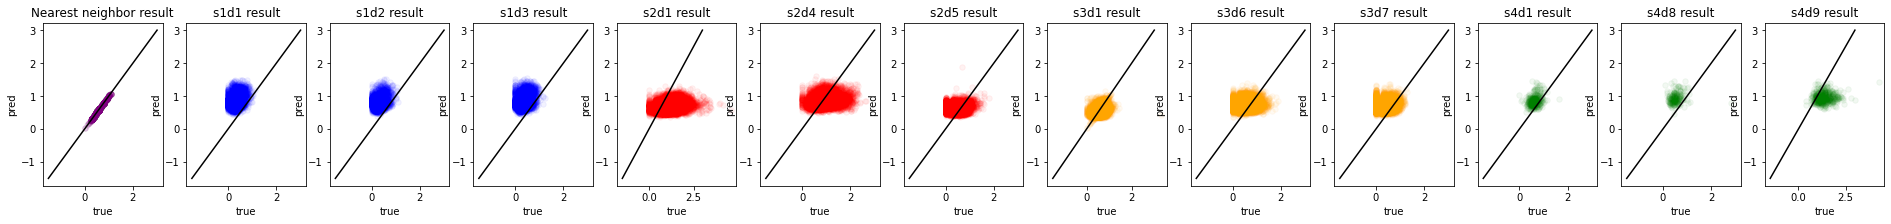

Epoch  3100 near loss: 0.0020423217 s1d1:  0.583353 s1d2:  0.5517404 s1d3:  0.5361413 s2d1: 0.7027687 s2d4: 0.46672216 s2d5: 0.38348448 s3d1: 0.20053403 s3d6: 0.40094545 s3d7: 0.44979802 s4d1: 0.3229724 s4d8: 0.49745274 s4d9: 0.5787332 test loss: 0.4896915644128291
Epoch  3200 near loss: 0.0020134167 s1d1:  0.5784991 s1d2:  0.5466682 s1d3:  0.531416 s2d1: 0.70507616 s2d4: 0.4673006 s2d5: 0.38146758 s3d1: 0.20052104 s3d6: 0.39855465 s3d7: 0.44662243 s4d1: 0.31852287 s4d8: 0.49209002 s4d9: 0.58284146 test loss: 0.4898330033719003
Epoch  3300 near loss: 0.0016176238 s1d1:  0.5777276 s1d2:  0.54517853 s1d3:  0.53092694 s2d1: 0.7050812 s2d4: 0.4674321 s2d5: 0.38120988 s3d1: 0.20055863 s3d6: 0.39848217 s3d7: 0.44626433 s4d1: 0.31771886 s4d8: 0.49070528 s4d9: 0.5838144 test loss: 0.48990285811868517
Epoch  3400 near loss: 0.0018548483 s1d1:  0.5755823 s1d2:  0.54273325 s1d3:  0.52940017 s2d1: 0.7056533 s2d4: 0.4677052 s2d5: 0.38080814 s3d1: 0.20054749 s3d6: 0.39777845 s3d7: 0.4449569 s4d1: 0.

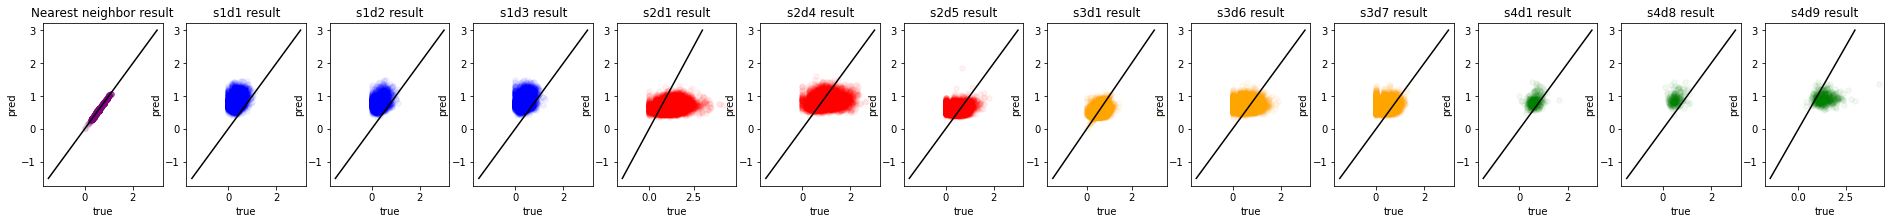

Epoch  4100 near loss: 0.0016255612 s1d1:  0.55782336 s1d2:  0.52306587 s1d3:  0.51321876 s2d1: 0.712377 s2d4: 0.4706422 s2d5: 0.37484595 s3d1: 0.20049034 s3d6: 0.39080325 s3d7: 0.4342482 s4d1: 0.29990917 s4d8: 0.46772024 s4d9: 0.6005919 test loss: 0.4908072479670916
Epoch  4200 near loss: 0.0013792147 s1d1:  0.5560046 s1d2:  0.52092546 s1d3:  0.51178604 s2d1: 0.71285784 s2d4: 0.47093186 s2d5: 0.3744309 s3d1: 0.20052417 s3d6: 0.39027396 s3d7: 0.43352017 s4d1: 0.29855517 s4d8: 0.46571937 s4d9: 0.60200626 test loss: 0.4909330022364251
Epoch  4300 near loss: 0.0024110638 s1d1:  0.5508605 s1d2:  0.5157587 s1d3:  0.50694156 s2d1: 0.7154197 s2d4: 0.47194618 s2d5: 0.372316 s3d1: 0.20045057 s3d6: 0.3881292 s3d7: 0.43012637 s4d1: 0.29436004 s4d8: 0.46073532 s4d9: 0.6059673 test loss: 0.49135002596934574
Epoch  4400 near loss: 0.001543071 s1d1:  0.5518892 s1d2:  0.5170281 s1d3:  0.50846064 s2d1: 0.7141366 s2d4: 0.47171795 s2d5: 0.3736492 s3d1: 0.20045917 s3d6: 0.38909578 s3d7: 0.4311265 s4d1: 0.

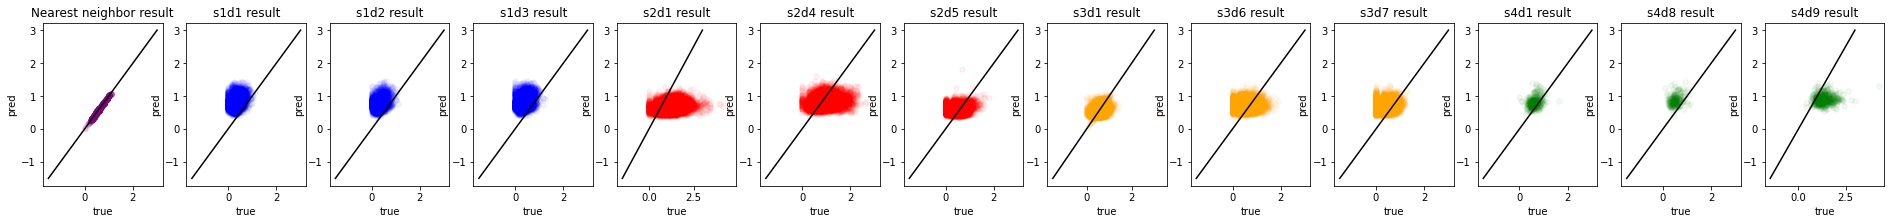

Epoch  5100 near loss: 0.0011329068 s1d1:  0.5375097 s1d2:  0.5006617 s1d3:  0.4955616 s2d1: 0.71969146 s2d4: 0.47506195 s2d5: 0.36893973 s3d1: 0.20053652 s3d6: 0.3837745 s3d7: 0.4223761 s4d1: 0.28278768 s4d8: 0.44518647 s4d9: 0.6177626 test loss: 0.4928525229066222
Epoch  5200 near loss: 0.0012538265 s1d1:  0.53603023 s1d2:  0.4990542 s1d3:  0.49431995 s2d1: 0.72006273 s2d4: 0.47525606 s2d5: 0.36858618 s3d1: 0.20053913 s3d6: 0.3833029 s3d7: 0.42207345 s4d1: 0.2818017 s4d8: 0.44365403 s4d9: 0.6191722 test loss: 0.493189654496403
Epoch  5300 near loss: 0.001273174 s1d1:  0.53401685 s1d2:  0.4971219 s1d3:  0.49238858 s2d1: 0.7210374 s2d4: 0.4757734 s2d5: 0.36793447 s3d1: 0.20047522 s3d6: 0.3825107 s3d7: 0.42058253 s4d1: 0.280031 s4d8: 0.44157606 s4d9: 0.62083066 test loss: 0.49342364695226704
Epoch  5400 near loss: 0.0014099688 s1d1:  0.5316872 s1d2:  0.4946674 s1d3:  0.49045882 s2d1: 0.72202754 s2d4: 0.47631872 s2d5: 0.36716616 s3d1: 0.20046501 s3d6: 0.38168624 s3d7: 0.41917008 s4d1: 0.

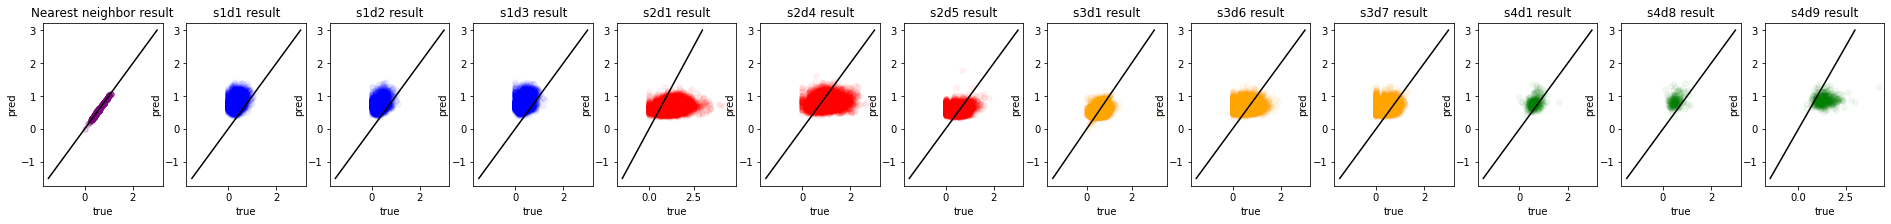

Epoch  6100 near loss: 0.0011807786 s1d1:  0.5223144 s1d2:  0.48387495 s1d3:  0.48241046 s2d1: 0.7252875 s2d4: 0.47893953 s2d5: 0.3645275 s3d1: 0.20053382 s3d6: 0.3785871 s3d7: 0.413835 s4d1: 0.2706317 s4d8: 0.42848176 s4d9: 0.6314806 test loss: 0.4954811236659892
Epoch  6200 near loss: 0.001609662 s1d1:  0.5188093 s1d2:  0.4803499 s1d3:  0.47908103 s2d1: 0.72707593 s2d4: 0.4798356 s2d5: 0.3632006 s3d1: 0.20046048 s3d6: 0.37709638 s3d7: 0.41178653 s4d1: 0.2676979 s4d8: 0.42467478 s4d9: 0.63476837 test loss: 0.4961981592167408
Epoch  6300 near loss: 0.0010887069 s1d1:  0.5187207 s1d2:  0.48013347 s1d3:  0.47914323 s2d1: 0.7269465 s2d4: 0.47988904 s2d5: 0.36342606 s3d1: 0.20049754 s3d6: 0.37717652 s3d7: 0.4117635 s4d1: 0.26761195 s4d8: 0.42435142 s4d9: 0.6348901 test loss: 0.4961968804642884
Epoch  6400 near loss: 0.0010923008 s1d1:  0.51867086 s1d2:  0.4795646 s1d3:  0.47917026 s2d1: 0.72675496 s2d4: 0.4800239 s2d5: 0.36337364 s3d1: 0.2005746 s3d6: 0.3773539 s3d7: 0.41168392 s4d1: 0.267

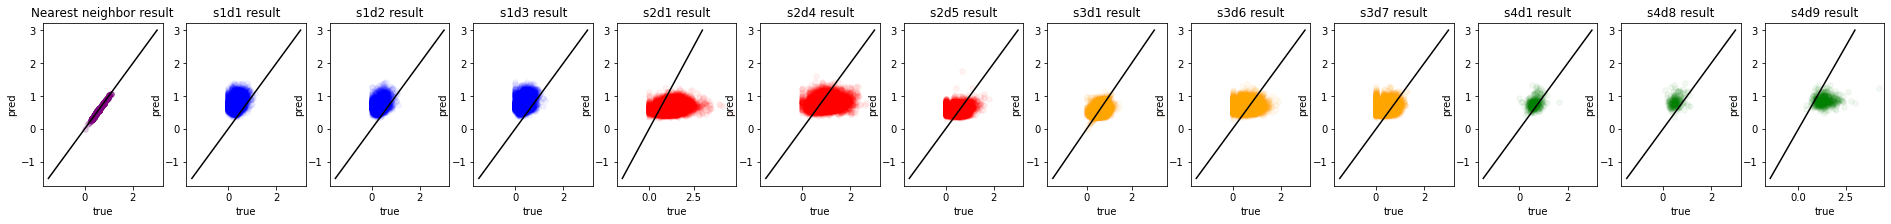

Epoch  7100 near loss: 0.0011940371 s1d1:  0.5096708 s1d2:  0.46987984 s1d3:  0.47147483 s2d1: 0.7306366 s2d4: 0.48285455 s2d5: 0.36067125 s3d1: 0.20058484 s3d6: 0.37399673 s3d7: 0.4060157 s4d1: 0.2605966 s4d8: 0.41427183 s4d9: 0.64325845 test loss: 0.4981298946375865
Epoch  7200 near loss: 0.0011113415 s1d1:  0.5092123 s1d2:  0.4698644 s1d3:  0.47105238 s2d1: 0.7304216 s2d4: 0.48279792 s2d5: 0.36098948 s3d1: 0.20045029 s3d6: 0.37414968 s3d7: 0.40617368 s4d1: 0.2604635 s4d8: 0.41457406 s4d9: 0.6430777 test loss: 0.498051547458647
Epoch  7300 near loss: 0.00097161916 s1d1:  0.50893885 s1d2:  0.4691738 s1d3:  0.4709121 s2d1: 0.73068804 s2d4: 0.48294058 s2d5: 0.36066395 s3d1: 0.20053893 s3d6: 0.37391222 s3d7: 0.405807 s4d1: 0.25996634 s4d8: 0.4134348 s4d9: 0.64399356 test loss: 0.49831188219891676
Epoch  7400 near loss: 0.0010304675 s1d1:  0.5080199 s1d2:  0.46798328 s1d3:  0.47006106 s2d1: 0.7311175 s2d4: 0.4833178 s2d5: 0.3602679 s3d1: 0.20056738 s3d6: 0.37354037 s3d7: 0.40526712 s4d1: 

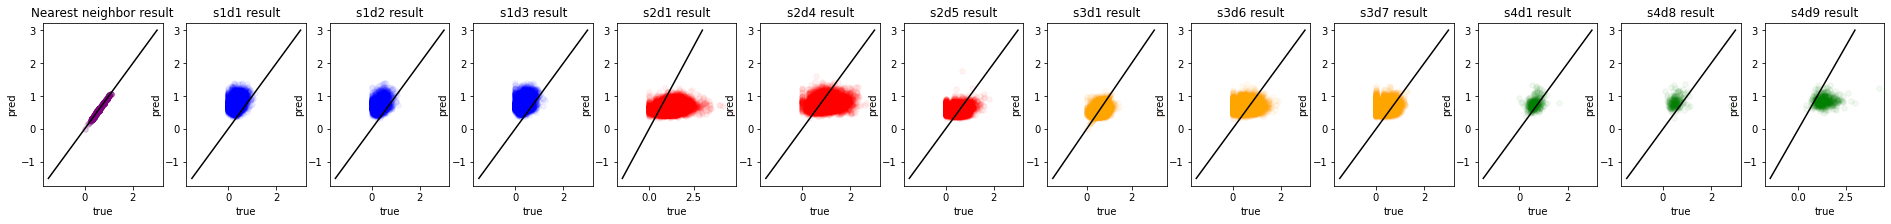

Epoch  8100 near loss: 0.0011055083 s1d1:  0.50358254 s1d2:  0.46300372 s1d3:  0.46649098 s2d1: 0.7325969 s2d4: 0.48487633 s2d5: 0.35927725 s3d1: 0.20061612 s3d6: 0.37230283 s3d7: 0.40255427 s4d1: 0.25595865 s4d8: 0.4076773 s4d9: 0.6490048 test loss: 0.49961949401581707
Epoch  8200 near loss: 0.00095332204 s1d1:  0.50250447 s1d2:  0.46174794 s1d3:  0.46555954 s2d1: 0.73317367 s2d4: 0.4852294 s2d5: 0.35888305 s3d1: 0.20061074 s3d6: 0.37175274 s3d7: 0.4019002 s4d1: 0.25497288 s4d8: 0.40611258 s4d9: 0.65024066 test loss: 0.49992482554546713
Epoch  8300 near loss: 0.0010465002 s1d1:  0.50116676 s1d2:  0.46049935 s1d3:  0.46425512 s2d1: 0.7338853 s2d4: 0.48562443 s2d5: 0.35833213 s3d1: 0.2005525 s3d6: 0.37124136 s3d7: 0.4011567 s4d1: 0.25376877 s4d8: 0.40452468 s4d9: 0.6516374 test loss: 0.5002883214695623
Epoch  8400 near loss: 0.001041687 s1d1:  0.5011161 s1d2:  0.4599037 s1d3:  0.46436825 s2d1: 0.73380107 s2d4: 0.48574573 s2d5: 0.3582008 s3d1: 0.20063518 s3d6: 0.37119076 s3d7: 0.40104085

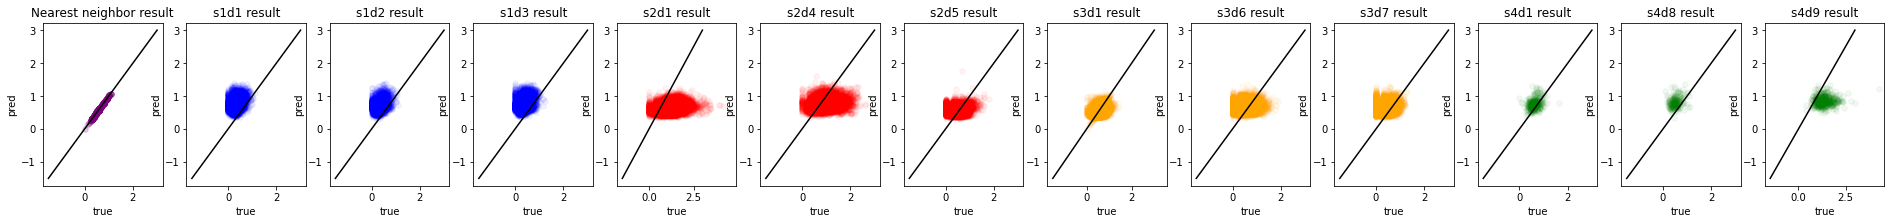

Epoch  9100 near loss: 0.0014294697 s1d1:  0.49617282 s1d2:  0.4548748 s1d3:  0.4601776 s2d1: 0.7359618 s2d4: 0.4874448 s2d5: 0.3569668 s3d1: 0.20060402 s3d6: 0.36952505 s3d7: 0.3980494 s4d1: 0.2502028 s4d8: 0.39935985 s4d9: 0.65633273 test loss: 0.5016449056946813
Epoch  9200 near loss: 0.00095344 s1d1:  0.4958408 s1d2:  0.4542928 s1d3:  0.45972863 s2d1: 0.736019 s2d4: 0.48753077 s2d5: 0.35675895 s3d1: 0.20058534 s3d6: 0.36948752 s3d7: 0.39799356 s4d1: 0.25004768 s4d8: 0.39921767 s4d9: 0.65663946 test loss: 0.5017798670535687
Epoch  9300 near loss: 0.0011134552 s1d1:  0.49520266 s1d2:  0.45347652 s1d3:  0.45925984 s2d1: 0.73639375 s2d4: 0.48790875 s2d5: 0.3565187 s3d1: 0.2006185 s3d6: 0.3692209 s3d7: 0.3974577 s4d1: 0.24946605 s4d8: 0.3981218 s4d9: 0.65747315 test loss: 0.5020039737120141
Epoch  9400 near loss: 0.00081595057 s1d1:  0.4947359 s1d2:  0.4530779 s1d3:  0.45883724 s2d1: 0.7364585 s2d4: 0.48806208 s2d5: 0.3565125 s3d1: 0.20062806 s3d6: 0.36919418 s3d7: 0.39729166 s4d1: 0.24

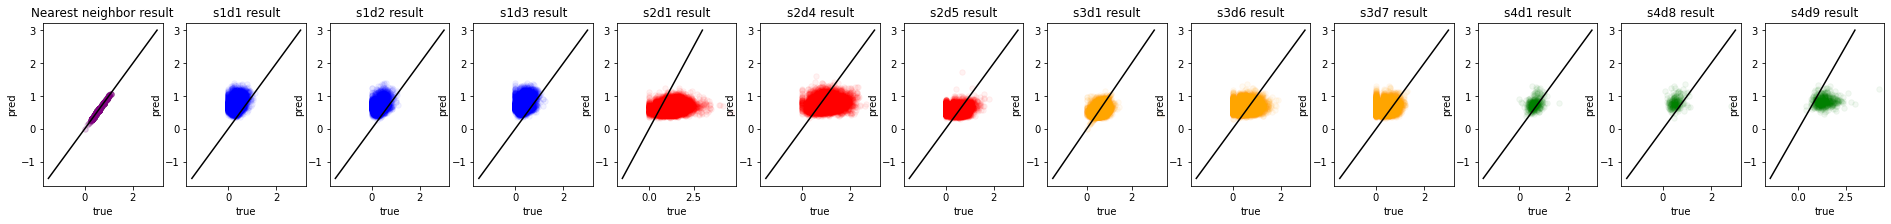

Epoch  10100 near loss: 0.00091983506 s1d1:  0.49125764 s1d2:  0.44873625 s1d3:  0.45595294 s2d1: 0.73799425 s2d4: 0.4893775 s2d5: 0.3552846 s3d1: 0.20070472 s3d6: 0.36781323 s3d7: 0.39498445 s4d1: 0.24651662 s4d8: 0.39338896 s4d9: 0.66174555 test loss: 0.5033199508585757
Epoch  10200 near loss: 0.00085516466 s1d1:  0.49112296 s1d2:  0.4489449 s1d3:  0.45599234 s2d1: 0.7377942 s2d4: 0.4893125 s2d5: 0.35553974 s3d1: 0.20063503 s3d6: 0.36795485 s3d7: 0.39513707 s4d1: 0.24668561 s4d8: 0.39371336 s4d9: 0.6612805 test loss: 0.5031195390224258
Epoch  10300 near loss: 0.0009201346 s1d1:  0.49062 s1d2:  0.4481177 s1d3:  0.45537806 s2d1: 0.73809814 s2d4: 0.48956788 s2d5: 0.3552308 s3d1: 0.20067242 s3d6: 0.36770883 s3d7: 0.3947663 s4d1: 0.24615173 s4d8: 0.39296746 s4d9: 0.6619992 test loss: 0.5033452682688331
Epoch  10400 near loss: 0.000912222 s1d1:  0.49016616 s1d2:  0.44798112 s1d3:  0.4551219 s2d1: 0.7381498 s2d4: 0.48965657 s2d5: 0.3552805 s3d1: 0.20062774 s3d6: 0.36767396 s3d7: 0.3947049 s

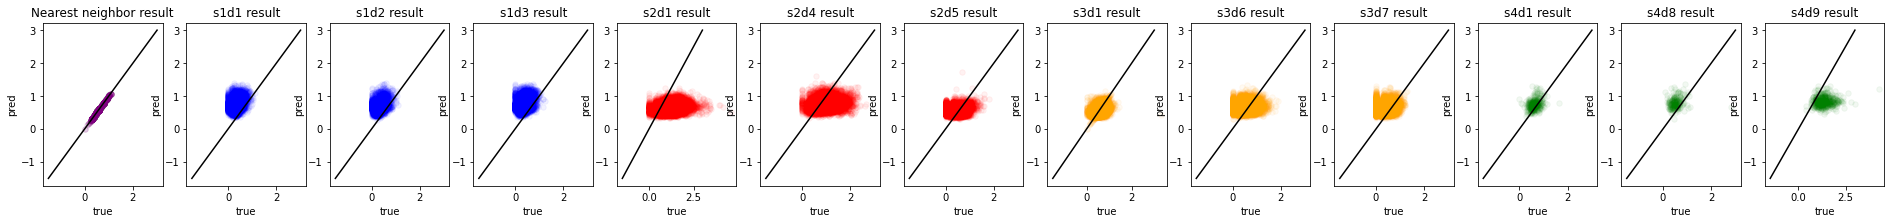

Epoch  11100 near loss: 0.0010067842 s1d1:  0.48694384 s1d2:  0.4445809 s1d3:  0.4523601 s2d1: 0.73952466 s2d4: 0.49077627 s2d5: 0.354502 s3d1: 0.20057985 s3d6: 0.36661565 s3d7: 0.39295045 s4d1: 0.24362925 s4d8: 0.3892978 s4d9: 0.6652352 test loss: 0.5043024528115169
Epoch  11200 near loss: 0.0007865799 s1d1:  0.48781323 s1d2:  0.4447057 s1d3:  0.45323363 s2d1: 0.739295 s2d4: 0.4908118 s2d5: 0.35443407 s3d1: 0.20073499 s3d6: 0.36681694 s3d7: 0.39281613 s4d1: 0.24399857 s4d8: 0.38943794 s4d9: 0.6650048 test loss: 0.5042449809232656
Epoch  11300 near loss: 0.00091427955 s1d1:  0.4868567 s1d2:  0.44389808 s1d3:  0.45242846 s2d1: 0.73990405 s2d4: 0.49109903 s2d5: 0.3540375 s3d1: 0.20070016 s3d6: 0.3663196 s3d7: 0.3923022 s4d1: 0.24323326 s4d8: 0.38832423 s4d9: 0.66614646 test loss: 0.5046352286994155
Epoch  11400 near loss: 0.0010310643 s1d1:  0.48706004 s1d2:  0.44442433 s1d3:  0.45266774 s2d1: 0.7393447 s2d4: 0.49081275 s2d5: 0.3545276 s3d1: 0.20063224 s3d6: 0.36681864 s3d7: 0.3929768 s4

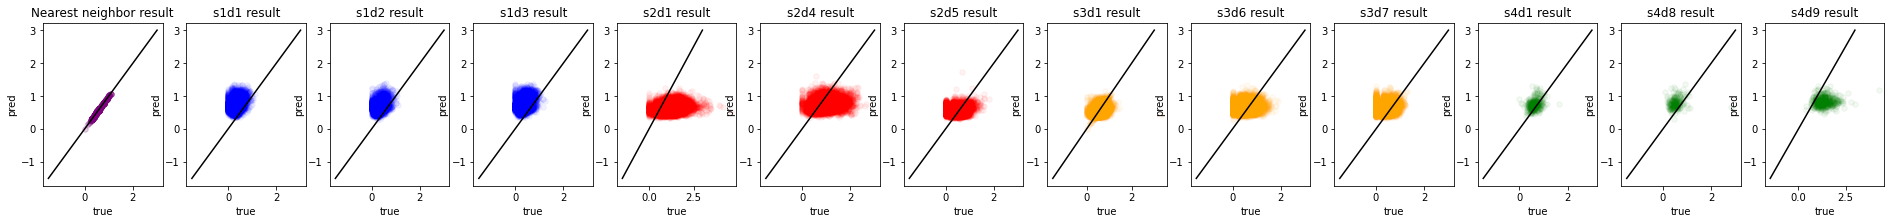

Epoch  12100 near loss: 0.0010657066 s1d1:  0.4837273 s1d2:  0.44066483 s1d3:  0.44961524 s2d1: 0.7413403 s2d4: 0.49229652 s2d5: 0.35315973 s3d1: 0.20068103 s3d6: 0.365324 s3d7: 0.3904406 s4d1: 0.24121912 s4d8: 0.38540608 s4d9: 0.6690083 test loss: 0.5055860739440073
Epoch  12200 near loss: 0.001437418 s1d1:  0.48379257 s1d2:  0.44062418 s1d3:  0.4496681 s2d1: 0.7411801 s2d4: 0.49217233 s2d5: 0.353108 s3d1: 0.20066935 s3d6: 0.36531425 s3d7: 0.3906825 s4d1: 0.2412697 s4d8: 0.3852142 s4d9: 0.6691133 test loss: 0.5056276215896733
Epoch  12300 near loss: 0.0008015534 s1d1:  0.48478785 s1d2:  0.4419763 s1d3:  0.4508308 s2d1: 0.7403608 s2d4: 0.49180573 s2d5: 0.35387504 s3d1: 0.20068751 s3d6: 0.3659694 s3d7: 0.3913663 s4d1: 0.24203748 s4d8: 0.38652393 s4d9: 0.6675907 test loss: 0.5050329454797879
Epoch  12400 near loss: 0.00077241735 s1d1:  0.48423716 s1d2:  0.4412156 s1d3:  0.45030662 s2d1: 0.7406957 s2d4: 0.49196932 s2d5: 0.35353935 s3d1: 0.20067772 s3d6: 0.36573198 s3d7: 0.3910243 s4d1: 0.

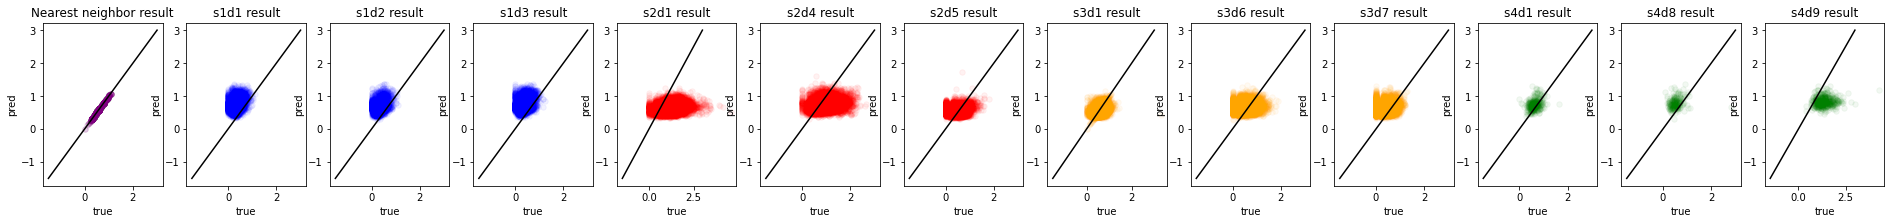

Epoch  13100 near loss: 0.00093069195 s1d1:  0.48176455 s1d2:  0.43804914 s1d3:  0.44816098 s2d1: 0.7419226 s2d4: 0.4930747 s2d5: 0.35264313 s3d1: 0.2007333 s3d6: 0.3646781 s3d7: 0.3893473 s4d1: 0.23968793 s4d8: 0.38263997 s4d9: 0.6713003 test loss: 0.5063018838836403
Epoch  13200 near loss: 0.00082274515 s1d1:  0.48127773 s1d2:  0.43752956 s1d3:  0.44781595 s2d1: 0.7422217 s2d4: 0.4932776 s2d5: 0.35253704 s3d1: 0.2007467 s3d6: 0.3645126 s3d7: 0.38894823 s4d1: 0.2395251 s4d8: 0.38235426 s4d9: 0.6715368 test loss: 0.5063754242481158
Epoch  13300 near loss: 0.0007429419 s1d1:  0.4819968 s1d2:  0.43836135 s1d3:  0.448524 s2d1: 0.7416086 s2d4: 0.49293408 s2d5: 0.35290477 s3d1: 0.2007693 s3d6: 0.36491582 s3d7: 0.38958398 s4d1: 0.24002916 s4d8: 0.38317022 s4d9: 0.6708088 test loss: 0.5061398489423888
Epoch  13400 near loss: 0.0009646649 s1d1:  0.4811475 s1d2:  0.43722892 s1d3:  0.44756743 s2d1: 0.7421777 s2d4: 0.49342757 s2d5: 0.35239428 s3d1: 0.20078097 s3d6: 0.36451894 s3d7: 0.38884556 s4d

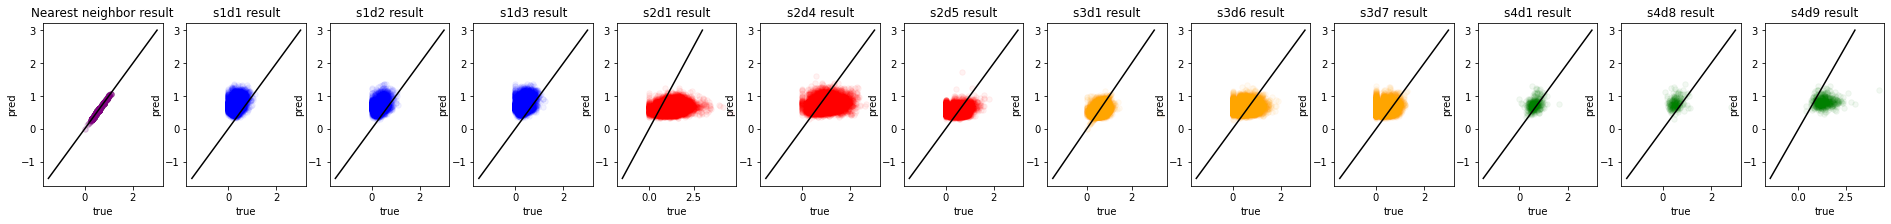

Epoch  14100 near loss: 0.00092044077 s1d1:  0.47960955 s1d2:  0.4355683 s1d3:  0.4463809 s2d1: 0.7426595 s2d4: 0.4938578 s2d5: 0.3521574 s3d1: 0.20074783 s3d6: 0.36404052 s3d7: 0.38823727 s4d1: 0.23843963 s4d8: 0.3804326 s4d9: 0.6733118 test loss: 0.5069862511655633
Epoch  14200 near loss: 0.00077796116 s1d1:  0.47996888 s1d2:  0.43613017 s1d3:  0.4467647 s2d1: 0.74251676 s2d4: 0.49381754 s2d5: 0.35238928 s3d1: 0.20076476 s3d6: 0.36419386 s3d7: 0.3882565 s4d1: 0.23875526 s4d8: 0.3808986 s4d9: 0.6726458 test loss: 0.506702419444847
Epoch  14300 near loss: 0.0008271032 s1d1:  0.47924823 s1d2:  0.43529958 s1d3:  0.4460961 s2d1: 0.74288553 s2d4: 0.4940599 s2d5: 0.35204294 s3d1: 0.20072925 s3d6: 0.36390817 s3d7: 0.38782465 s4d1: 0.23824652 s4d8: 0.38001275 s4d9: 0.6734394 test loss: 0.5069685070366104
Epoch  14400 near loss: 0.0007407393 s1d1:  0.47910866 s1d2:  0.43518057 s1d3:  0.44613242 s2d1: 0.7430243 s2d4: 0.49409944 s2d5: 0.35206813 s3d1: 0.20073108 s3d6: 0.36388358 s3d7: 0.38764906

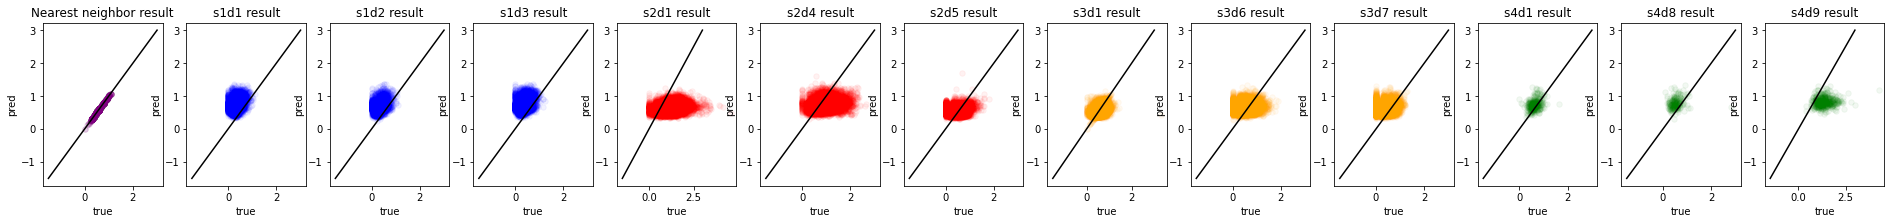

Epoch  15100 near loss: 0.00082622323 s1d1:  0.4778535 s1d2:  0.43382886 s1d3:  0.44507045 s2d1: 0.7435477 s2d4: 0.49457073 s2d5: 0.35165432 s3d1: 0.2006951 s3d6: 0.36340755 s3d7: 0.38703594 s4d1: 0.23726328 s4d8: 0.3786684 s4d9: 0.6748773 test loss: 0.5074836703533746
Epoch  15200 near loss: 0.00090223463 s1d1:  0.4784271 s1d2:  0.43398607 s1d3:  0.4456065 s2d1: 0.7434054 s2d4: 0.49455124 s2d5: 0.3516039 s3d1: 0.20079032 s3d6: 0.36349544 s3d7: 0.3870193 s4d1: 0.2374607 s4d8: 0.37856123 s4d9: 0.67486024 test loss: 0.5074875561431743
Epoch  15300 near loss: 0.00086976273 s1d1:  0.47778258 s1d2:  0.43309587 s1d3:  0.44515094 s2d1: 0.7438253 s2d4: 0.4948538 s2d5: 0.35129637 s3d1: 0.2007966 s3d6: 0.36319074 s3d7: 0.3864715 s4d1: 0.23696913 s4d8: 0.37771785 s4d9: 0.675722 test loss: 0.5078069618583342
Epoch  15400 near loss: 0.0011466355 s1d1:  0.47637364 s1d2:  0.4322324 s1d3:  0.44370088 s2d1: 0.7445635 s2d4: 0.4953016 s2d5: 0.35104814 s3d1: 0.2006946 s3d6: 0.36277038 s3d7: 0.38580257 s4d

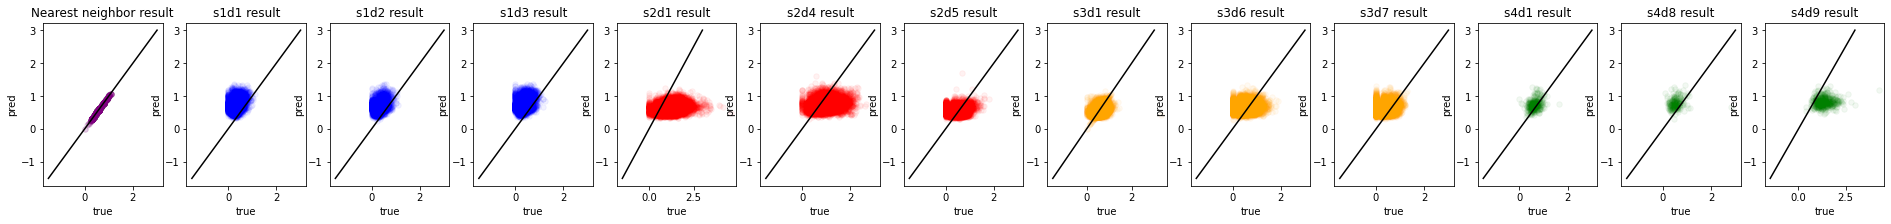

Epoch  16100 near loss: 0.0007424807 s1d1:  0.47587517 s1d2:  0.4316987 s1d3:  0.44342378 s2d1: 0.7442393 s2d4: 0.49532107 s2d5: 0.35119766 s3d1: 0.20066057 s3d6: 0.36283475 s3d7: 0.386016 s4d1: 0.23602791 s4d8: 0.37671754 s4d9: 0.6765319 test loss: 0.508001669773625
Epoch  16200 near loss: 0.00068641367 s1d1:  0.4763237 s1d2:  0.43192795 s1d3:  0.4438572 s2d1: 0.7441228 s2d4: 0.49525768 s2d5: 0.3511702 s3d1: 0.2007384 s3d6: 0.36296725 s3d7: 0.38614017 s4d1: 0.23619954 s4d8: 0.37676933 s4d9: 0.67632526 test loss: 0.5079099552393983
Epoch  16300 near loss: 0.0008218447 s1d1:  0.47549772 s1d2:  0.43113956 s1d3:  0.4431076 s2d1: 0.7447338 s2d4: 0.49563795 s2d5: 0.35081956 s3d1: 0.20073736 s3d6: 0.36252108 s3d7: 0.38554844 s4d1: 0.2354972 s4d8: 0.3758431 s4d9: 0.6774601 test loss: 0.5083529679536734
Epoch  16400 near loss: 0.0010848154 s1d1:  0.47616726 s1d2:  0.43167433 s1d3:  0.44369683 s2d1: 0.7442488 s2d4: 0.49538147 s2d5: 0.35101354 s3d1: 0.2007508 s3d6: 0.3627835 s3d7: 0.3858362 s4d1

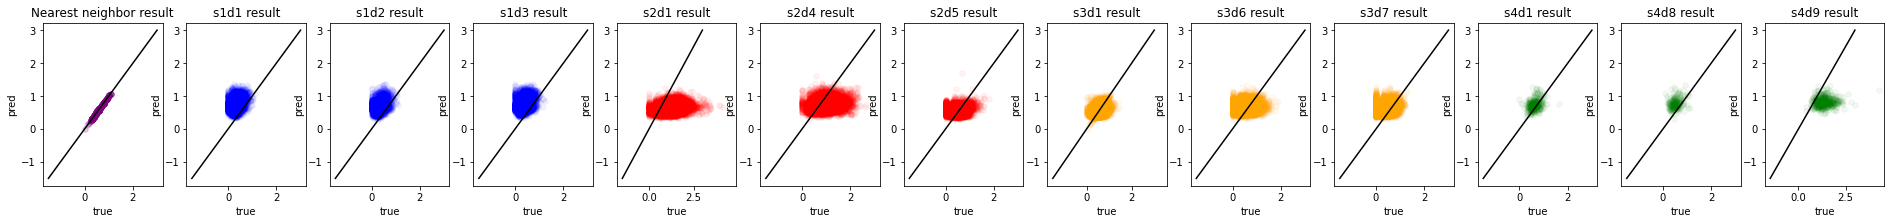

Epoch  17100 near loss: 0.0006739074 s1d1:  0.4754959 s1d2:  0.43079898 s1d3:  0.44315618 s2d1: 0.7444641 s2d4: 0.49570447 s2d5: 0.35087532 s3d1: 0.2007899 s3d6: 0.3627143 s3d7: 0.38549647 s4d1: 0.23574595 s4d8: 0.37578878 s4d9: 0.67736995 test loss: 0.5083280366301786
Epoch  17200 near loss: 0.00094270176 s1d1:  0.47442687 s1d2:  0.42991322 s1d3:  0.44218203 s2d1: 0.7451281 s2d4: 0.49605614 s2d5: 0.35052592 s3d1: 0.20071831 s3d6: 0.36221382 s3d7: 0.38481548 s4d1: 0.23503229 s4d8: 0.37471014 s4d9: 0.6783051 test loss: 0.5086251052004147
Epoch  17300 near loss: 0.0007466921 s1d1:  0.474931 s1d2:  0.43032208 s1d3:  0.44269094 s2d1: 0.7449269 s2d4: 0.49590614 s2d5: 0.35061085 s3d1: 0.20076221 s3d6: 0.3624111 s3d7: 0.38506982 s4d1: 0.23537716 s4d8: 0.37520334 s4d9: 0.6779657 test loss: 0.5085459324189839
Epoch  17400 near loss: 0.00078273105 s1d1:  0.4744952 s1d2:  0.43011057 s1d3:  0.44236094 s2d1: 0.7449813 s2d4: 0.4959869 s2d5: 0.35069126 s3d1: 0.20069876 s3d6: 0.36236432 s3d7: 0.384949

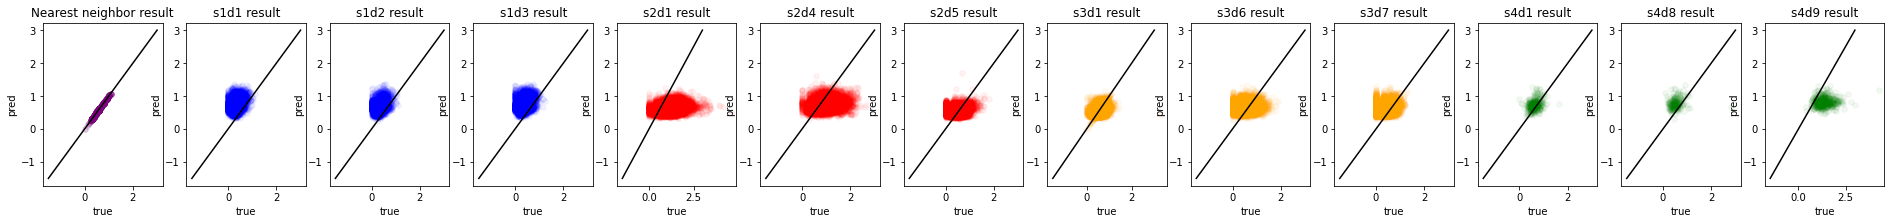

Epoch  18100 near loss: 0.0012160755 s1d1:  0.47354913 s1d2:  0.4291943 s1d3:  0.44145557 s2d1: 0.74545926 s2d4: 0.4963998 s2d5: 0.35037574 s3d1: 0.20068559 s3d6: 0.361988 s3d7: 0.38444483 s4d1: 0.23442641 s4d8: 0.37377638 s4d9: 0.67930436 test loss: 0.5090014854959969
Epoch  18200 near loss: 0.0007094957 s1d1:  0.47498524 s1d2:  0.43039984 s1d3:  0.44282416 s2d1: 0.7445074 s2d4: 0.49589875 s2d5: 0.3509161 s3d1: 0.20076424 s3d6: 0.36260477 s3d7: 0.38526726 s4d1: 0.2353574 s4d8: 0.37515134 s4d9: 0.6778332 test loss: 0.5084538568574845
Epoch  18300 near loss: 0.00071149133 s1d1:  0.47436967 s1d2:  0.42992118 s1d3:  0.44228342 s2d1: 0.7448181 s2d4: 0.49613634 s2d5: 0.350799 s3d1: 0.2007433 s3d6: 0.36244667 s3d7: 0.38498437 s4d1: 0.23500758 s4d8: 0.37467003 s4d9: 0.6783587 test loss: 0.5086479710463948
Epoch  18400 near loss: 0.0010533672 s1d1:  0.473549 s1d2:  0.42883608 s1d3:  0.44142354 s2d1: 0.7455275 s2d4: 0.49650022 s2d5: 0.3501923 s3d1: 0.2007293 s3d6: 0.36193752 s3d7: 0.38429514 s4

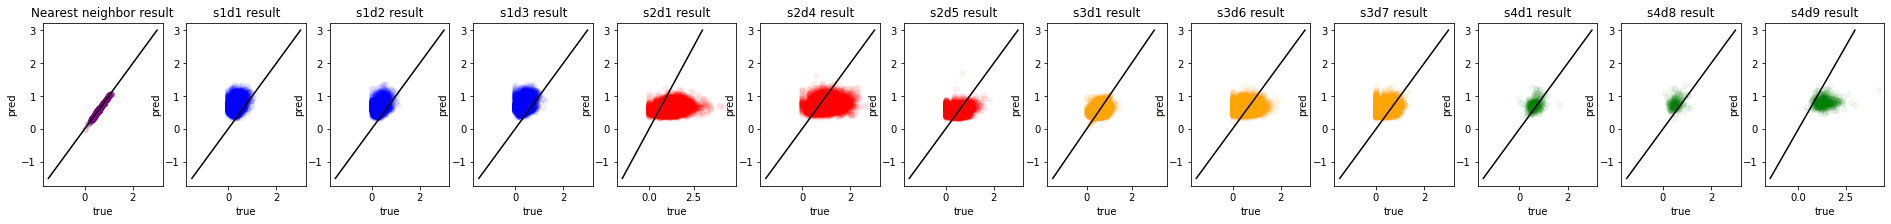

Epoch  19100 near loss: 0.00069446175 s1d1:  0.4738392 s1d2:  0.42885768 s1d3:  0.44199538 s2d1: 0.7452855 s2d4: 0.49647173 s2d5: 0.3503698 s3d1: 0.20081913 s3d6: 0.3621306 s3d7: 0.38430384 s4d1: 0.23451687 s4d8: 0.3735964 s4d9: 0.6793043 test loss: 0.508988015205031
Epoch  19200 near loss: 0.0006519969 s1d1:  0.47391623 s1d2:  0.42914253 s1d3:  0.44211605 s2d1: 0.7451603 s2d4: 0.49636394 s2d5: 0.3505224 s3d1: 0.20078632 s3d6: 0.36220473 s3d7: 0.3845955 s4d1: 0.23466755 s4d8: 0.37388626 s4d9: 0.6791047 test loss: 0.5089329960976992
Epoch  19300 near loss: 0.0006916515 s1d1:  0.47268125 s1d2:  0.42811415 s1d3:  0.44096908 s2d1: 0.745925 s2d4: 0.4967504 s2d5: 0.3501495 s3d1: 0.20070465 s3d6: 0.36180288 s3d7: 0.383948 s4d1: 0.23401509 s4d8: 0.37300515 s4d9: 0.67999935 test loss: 0.5092470521339441
Epoch  19400 near loss: 0.0007855791 s1d1:  0.47376317 s1d2:  0.4286647 s1d3:  0.44201526 s2d1: 0.7452315 s2d4: 0.49654832 s2d5: 0.35039517 s3d1: 0.20083849 s3d6: 0.36210012 s3d7: 0.3842211 s4d1

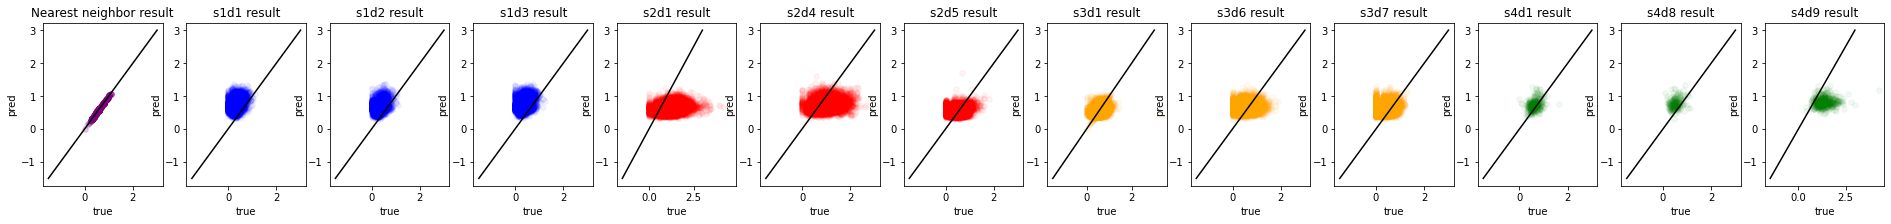

Epoch  20100 near loss: 0.00091399037 s1d1:  0.4724064 s1d2:  0.42765182 s1d3:  0.44074166 s2d1: 0.7461006 s2d4: 0.49696836 s2d5: 0.34989935 s3d1: 0.20074214 s3d6: 0.36157423 s3d7: 0.38368145 s4d1: 0.233583 s4d8: 0.3722047 s4d9: 0.6806761 test loss: 0.5094744957833462
Epoch  20200 near loss: 0.0007104053 s1d1:  0.47292456 s1d2:  0.42828378 s1d3:  0.44124585 s2d1: 0.7455577 s2d4: 0.4967155 s2d5: 0.35025895 s3d1: 0.2007506 s3d6: 0.36189258 s3d7: 0.38413423 s4d1: 0.23400438 s4d8: 0.3729238 s4d9: 0.6798599 test loss: 0.5091475887884749
Epoch  20300 near loss: 0.00085870526 s1d1:  0.4713807 s1d2:  0.42674148 s1d3:  0.43981448 s2d1: 0.7464237 s2d4: 0.49729833 s2d5: 0.34972256 s3d1: 0.20067275 s3d6: 0.36134937 s3d7: 0.3832189 s4d1: 0.2330764 s4d8: 0.37154794 s4d9: 0.6813397 test loss: 0.5097048551065191
Epoch  20400 near loss: 0.0010953877 s1d1:  0.47140336 s1d2:  0.42645305 s1d3:  0.43981087 s2d1: 0.7465857 s2d4: 0.4974079 s2d5: 0.34954274 s3d1: 0.20072627 s3d6: 0.3611795 s3d7: 0.38292608 s4

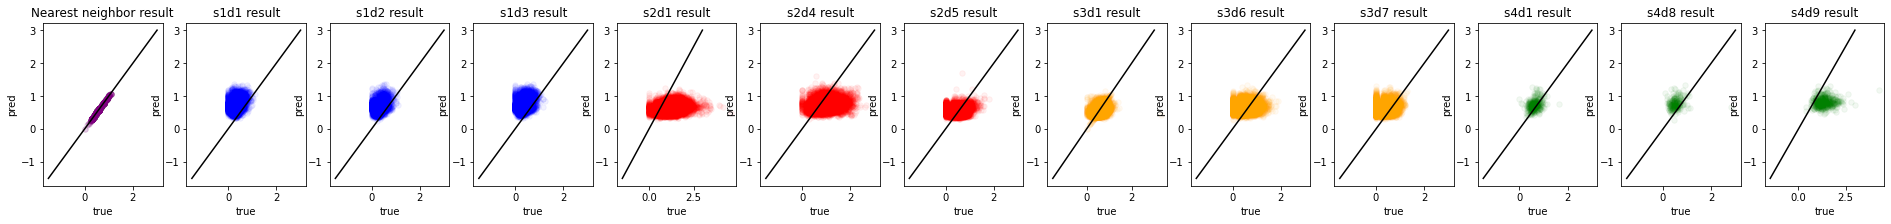

Epoch  21100 near loss: 0.0012304845 s1d1:  0.4707085 s1d2:  0.42599812 s1d3:  0.4392681 s2d1: 0.7468971 s2d4: 0.49772766 s2d5: 0.34947413 s3d1: 0.2006975 s3d6: 0.3610174 s3d7: 0.38251984 s4d1: 0.23260428 s4d8: 0.37085986 s4d9: 0.68201125 test loss: 0.5099412763816694
Epoch  21200 near loss: 0.00088849856 s1d1:  0.47106174 s1d2:  0.42628044 s1d3:  0.43961066 s2d1: 0.74664146 s2d4: 0.4975386 s2d5: 0.3496191 s3d1: 0.20070553 s3d6: 0.3611536 s3d7: 0.38281158 s4d1: 0.23277944 s4d8: 0.37091878 s4d9: 0.6818965 test loss: 0.5099064121002942
Epoch  21300 near loss: 0.000959048 s1d1:  0.47140983 s1d2:  0.42660344 s1d3:  0.43987286 s2d1: 0.7464849 s2d4: 0.49740633 s2d5: 0.34966764 s3d1: 0.20069844 s3d6: 0.36125243 s3d7: 0.38295513 s4d1: 0.23302051 s4d8: 0.3712502 s4d9: 0.6815083 test loss: 0.5097548861413831
Epoch  21400 near loss: 0.0006522441 s1d1:  0.47153908 s1d2:  0.4265805 s1d3:  0.44014972 s2d1: 0.74630165 s2d4: 0.49733382 s2d5: 0.34981298 s3d1: 0.20076397 s3d6: 0.3613115 s3d7: 0.38305387

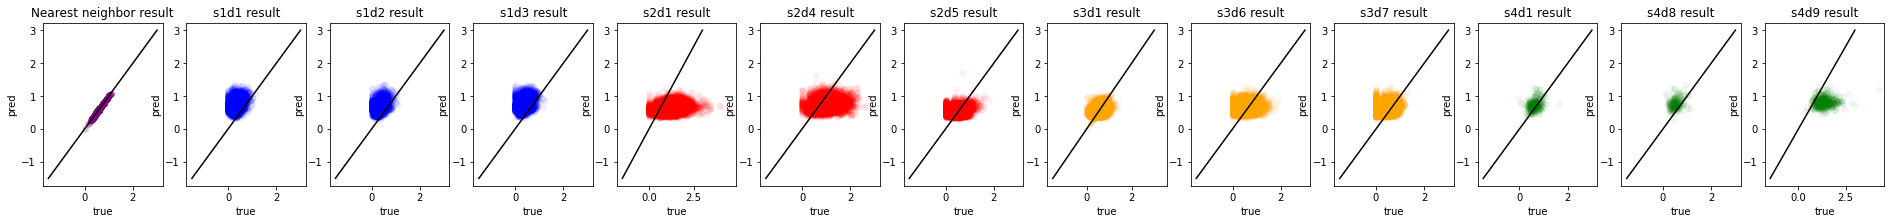

Epoch  22100 near loss: 0.0007652391 s1d1:  0.47165704 s1d2:  0.42674452 s1d3:  0.44043303 s2d1: 0.7461716 s2d4: 0.4973007 s2d5: 0.34996036 s3d1: 0.20076929 s3d6: 0.36146095 s3d7: 0.38331825 s4d1: 0.23317748 s4d8: 0.37127033 s4d9: 0.6812853 test loss: 0.5096450607259279
Epoch  22200 near loss: 0.0007196777 s1d1:  0.47100136 s1d2:  0.42605063 s1d3:  0.43978196 s2d1: 0.74668676 s2d4: 0.49758035 s2d5: 0.3495633 s3d1: 0.20074317 s3d6: 0.36109328 s3d7: 0.38277674 s4d1: 0.23275973 s4d8: 0.37061533 s4d9: 0.6821853 test loss: 0.5100350176748778
Epoch  22300 near loss: 0.0006150698 s1d1:  0.47108173 s1d2:  0.4257426 s1d3:  0.44002494 s2d1: 0.7467287 s2d4: 0.49775022 s2d5: 0.3494853 s3d1: 0.20084107 s3d6: 0.36110055 s3d7: 0.38255793 s4d1: 0.23279673 s4d8: 0.3704261 s4d9: 0.6823272 test loss: 0.5100993323157078
Epoch  22400 near loss: 0.00087817217 s1d1:  0.47141504 s1d2:  0.42641056 s1d3:  0.44018364 s2d1: 0.7461064 s2d4: 0.4973712 s2d5: 0.34992927 s3d1: 0.20075671 s3d6: 0.36141586 s3d7: 0.38320

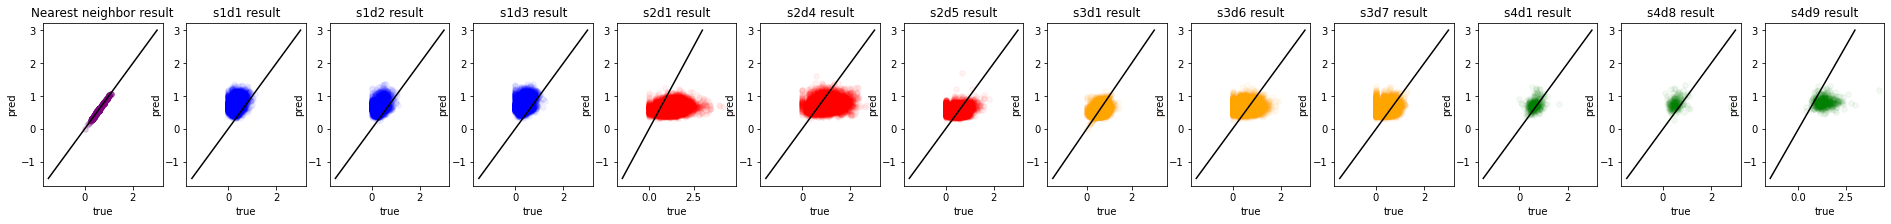

Epoch  23100 near loss: 0.0007578567 s1d1:  0.4710991 s1d2:  0.42573377 s1d3:  0.43991286 s2d1: 0.7464884 s2d4: 0.49767223 s2d5: 0.34952703 s3d1: 0.20081893 s3d6: 0.36114737 s3d7: 0.38262266 s4d1: 0.23280084 s4d8: 0.3705619 s4d9: 0.68208915 test loss: 0.5099742258562052
Epoch  23200 near loss: 0.001478048 s1d1:  0.4699758 s1d2:  0.42452464 s1d3:  0.4387878 s2d1: 0.7472476 s2d4: 0.49812657 s2d5: 0.34899095 s3d1: 0.20077635 s3d6: 0.36061183 s3d7: 0.38190994 s4d1: 0.23194778 s4d8: 0.3692258 s4d9: 0.68352795 test loss: 0.5105277170674424
Epoch  23300 near loss: 0.00081408 s1d1:  0.4703418 s1d2:  0.4253418 s1d3:  0.4393026 s2d1: 0.7468217 s2d4: 0.4978815 s2d5: 0.3494632 s3d1: 0.20076121 s3d6: 0.36093268 s3d7: 0.38234857 s4d1: 0.2323886 s4d8: 0.37004954 s4d9: 0.68259954 test loss: 0.5101478449200645
Epoch  23400 near loss: 0.0006967541 s1d1:  0.4710863 s1d2:  0.4258107 s1d3:  0.43987662 s2d1: 0.7463174 s2d4: 0.4977006 s2d5: 0.34974658 s3d1: 0.20082697 s3d6: 0.36129457 s3d7: 0.38272512 s4d1: 

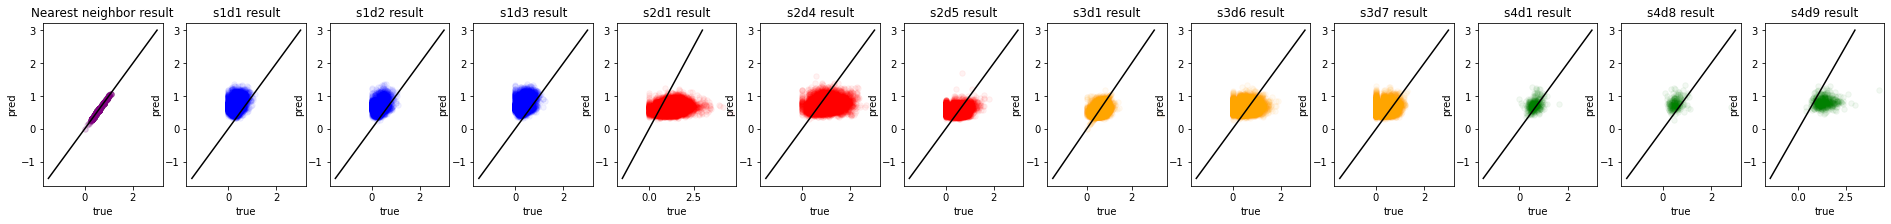

Epoch  24100 near loss: 0.0008225891 s1d1:  0.47045776 s1d2:  0.42520505 s1d3:  0.43954787 s2d1: 0.7467597 s2d4: 0.49791566 s2d5: 0.34956715 s3d1: 0.2008127 s3d6: 0.36100522 s3d7: 0.38241354 s4d1: 0.23247989 s4d8: 0.3700086 s4d9: 0.6826017 test loss: 0.5101569008713523
Epoch  24200 near loss: 0.00064776716 s1d1:  0.47066724 s1d2:  0.4250638 s1d3:  0.43956345 s2d1: 0.7468644 s2d4: 0.49797228 s2d5: 0.34930387 s3d1: 0.20087662 s3d6: 0.36097518 s3d7: 0.38220897 s4d1: 0.23246978 s4d8: 0.36991337 s4d9: 0.68278265 test loss: 0.5102522188514661
Epoch  24300 near loss: 0.00095235487 s1d1:  0.46978098 s1d2:  0.42443004 s1d3:  0.43871117 s2d1: 0.7472722 s2d4: 0.49821016 s2d5: 0.34909895 s3d1: 0.20079349 s3d6: 0.36064237 s3d7: 0.38190383 s4d1: 0.23190323 s4d8: 0.36913687 s4d9: 0.6835294 test loss: 0.510508528154394
Epoch  24400 near loss: 0.000507575 s1d1:  0.47000116 s1d2:  0.42463145 s1d3:  0.4390273 s2d1: 0.7471515 s2d4: 0.49813786 s2d5: 0.3491886 s3d1: 0.20081024 s3d6: 0.3607633 s3d7: 0.381983

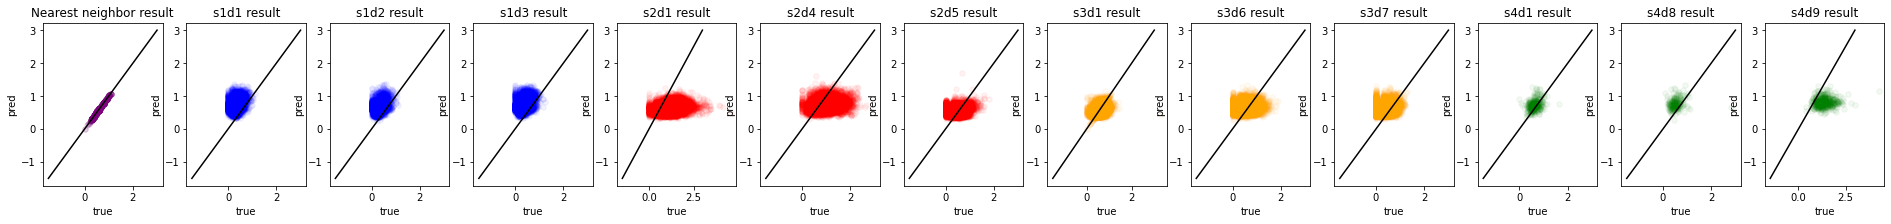

Epoch  25100 near loss: 0.0006993603 s1d1:  0.46930143 s1d2:  0.42362857 s1d3:  0.4383651 s2d1: 0.7474611 s2d4: 0.49842328 s2d5: 0.3488189 s3d1: 0.20079142 s3d6: 0.3604631 s3d7: 0.38158146 s4d1: 0.23174538 s4d8: 0.3687075 s4d9: 0.6839843 test loss: 0.5106999867949602
Epoch  25200 near loss: 0.00060671294 s1d1:  0.46940714 s1d2:  0.4238272 s1d3:  0.4385776 s2d1: 0.7473565 s2d4: 0.4984552 s2d5: 0.34893513 s3d1: 0.20078358 s3d6: 0.3604982 s3d7: 0.38150126 s4d1: 0.2316167 s4d8: 0.3684392 s4d9: 0.68406945 test loss: 0.5106927730149534
Epoch  25300 near loss: 0.0006823588 s1d1:  0.46994564 s1d2:  0.42447716 s1d3:  0.4390769 s2d1: 0.7469168 s2d4: 0.4981085 s2d5: 0.34922475 s3d1: 0.20078929 s3d6: 0.36081687 s3d7: 0.3820244 s4d1: 0.2322217 s4d8: 0.36947858 s4d9: 0.68314976 test loss: 0.5103747925871223
Epoch  25400 near loss: 0.0011312243 s1d1:  0.46911097 s1d2:  0.42383885 s1d3:  0.4381458 s2d1: 0.7476352 s2d4: 0.49843404 s2d5: 0.3488517 s3d1: 0.20073521 s3d6: 0.36034498 s3d7: 0.38156223 s4d1:

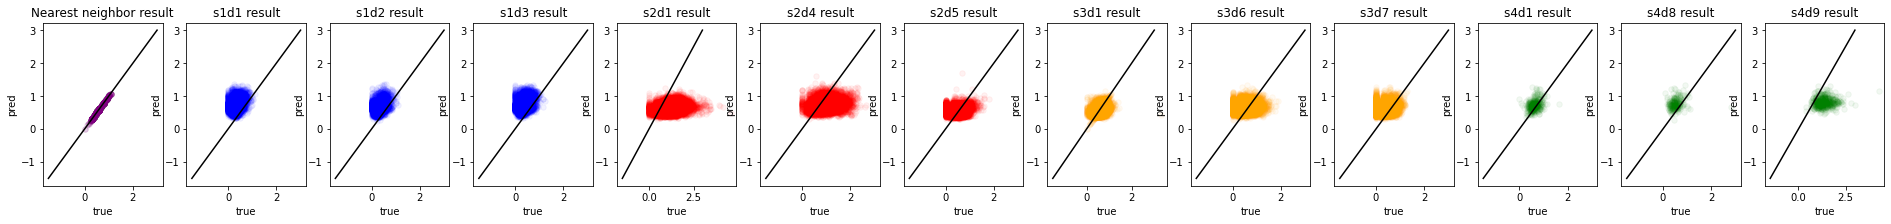

Epoch  26100 near loss: 0.00055974827 s1d1:  0.46923468 s1d2:  0.423359 s1d3:  0.43842217 s2d1: 0.7474901 s2d4: 0.49864218 s2d5: 0.34882575 s3d1: 0.20086293 s3d6: 0.36043614 s3d7: 0.38128754 s4d1: 0.23159142 s4d8: 0.36830157 s4d9: 0.6843095 test loss: 0.5108159787498207
Epoch  26200 near loss: 0.00091192016 s1d1:  0.46876973 s1d2:  0.42330775 s1d3:  0.43785414 s2d1: 0.74765795 s2d4: 0.49865156 s2d5: 0.3487632 s3d1: 0.20074737 s3d6: 0.36024237 s3d7: 0.38113466 s4d1: 0.23133683 s4d8: 0.36833113 s4d9: 0.6843531 test loss: 0.5108086826954756
Epoch  26300 near loss: 0.0006163474 s1d1:  0.46943688 s1d2:  0.42371324 s1d3:  0.43859896 s2d1: 0.74720174 s2d4: 0.49840248 s2d5: 0.3489889 s3d1: 0.20083317 s3d6: 0.36055246 s3d7: 0.38168287 s4d1: 0.2317667 s4d8: 0.36864623 s4d9: 0.6839817 test loss: 0.5106924818516309
Epoch  26400 near loss: 0.0006693312 s1d1:  0.46873477 s1d2:  0.42326927 s1d3:  0.43795836 s2d1: 0.7475851 s2d4: 0.49860242 s2d5: 0.34881148 s3d1: 0.20072842 s3d6: 0.36036327 s3d7: 0.38

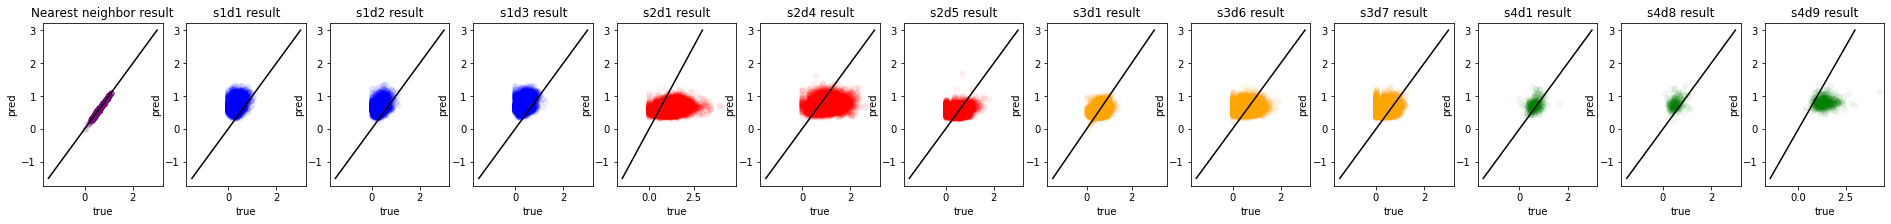

Epoch  27100 near loss: 0.00093973236 s1d1:  0.4683154 s1d2:  0.42266485 s1d3:  0.4376215 s2d1: 0.74794644 s2d4: 0.49895263 s2d5: 0.3485318 s3d1: 0.20079842 s3d6: 0.36005557 s3d7: 0.3807176 s4d1: 0.23099685 s4d8: 0.36751541 s4d9: 0.6851031 test loss: 0.511097055444609
Epoch  27200 near loss: 0.00071964576 s1d1:  0.46839094 s1d2:  0.4228702 s1d3:  0.43775412 s2d1: 0.7477449 s2d4: 0.49878678 s2d5: 0.3487447 s3d1: 0.20075265 s3d6: 0.36015508 s3d7: 0.38092676 s4d1: 0.23121335 s4d8: 0.36786294 s4d9: 0.6846577 test loss: 0.5109075072654712
Epoch  27300 near loss: 0.0009766066 s1d1:  0.46808502 s1d2:  0.42231402 s1d3:  0.4373963 s2d1: 0.7481553 s2d4: 0.49905846 s2d5: 0.3484259 s3d1: 0.20078276 s3d6: 0.35993958 s3d7: 0.38048548 s4d1: 0.23090495 s4d8: 0.3672038 s4d9: 0.68526167 test loss: 0.5111343766765399
Epoch  27400 near loss: 0.00076960877 s1d1:  0.46788692 s1d2:  0.42224476 s1d3:  0.437246 s2d1: 0.74818665 s2d4: 0.49907345 s2d5: 0.34841987 s3d1: 0.2007798 s3d6: 0.35993028 s3d7: 0.3805522 

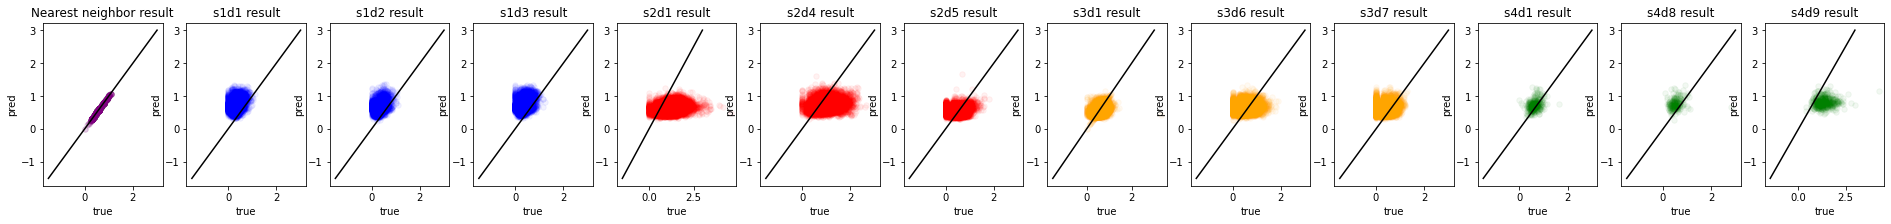

Epoch  28100 near loss: 0.0006661417 s1d1:  0.4675494 s1d2:  0.4219725 s1d3:  0.43695408 s2d1: 0.74816924 s2d4: 0.49918103 s2d5: 0.348471 s3d1: 0.20074074 s3d6: 0.35990924 s3d7: 0.38046336 s4d1: 0.23070419 s4d8: 0.36709535 s4d9: 0.68540955 test loss: 0.5111789906406027
Epoch  28200 near loss: 0.0010894286 s1d1:  0.46675357 s1d2:  0.42109582 s1d3:  0.43618283 s2d1: 0.7485898 s2d4: 0.4994444 s2d5: 0.3481059 s3d1: 0.20069996 s3d6: 0.35959125 s3d7: 0.37994158 s4d1: 0.23019263 s4d8: 0.3662501 s4d9: 0.68634397 test loss: 0.5115518024615892
Epoch  28300 near loss: 0.00055052363 s1d1:  0.46808383 s1d2:  0.4223007 s1d3:  0.43753758 s2d1: 0.7477716 s2d4: 0.49889466 s2d5: 0.34862924 s3d1: 0.20077215 s3d6: 0.36008856 s3d7: 0.3807448 s4d1: 0.23096864 s4d8: 0.36728248 s4d9: 0.6851741 test loss: 0.511101817451057
Epoch  28400 near loss: 0.00071018114 s1d1:  0.46845725 s1d2:  0.42252386 s1d3:  0.43782166 s2d1: 0.74778545 s2d4: 0.49893633 s2d5: 0.34858245 s3d1: 0.20082885 s3d6: 0.36009976 s3d7: 0.38077

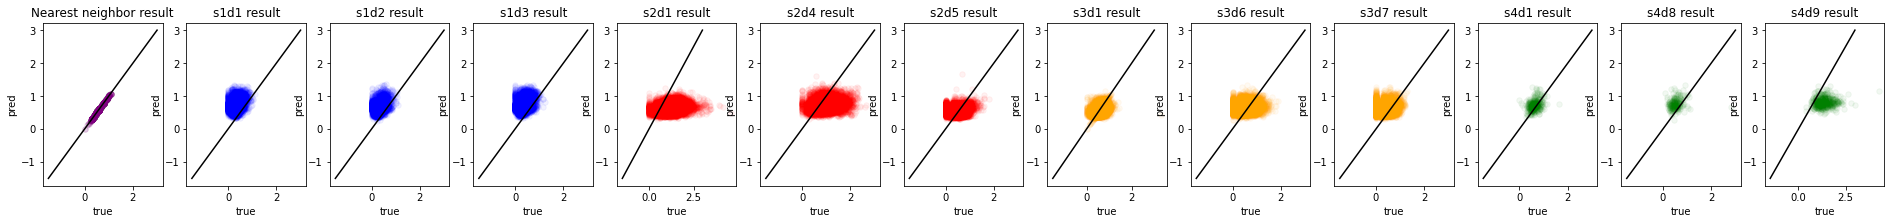

Epoch  29100 near loss: 0.00070728094 s1d1:  0.46733057 s1d2:  0.42134 s1d3:  0.43689135 s2d1: 0.7481356 s2d4: 0.49932963 s2d5: 0.34829378 s3d1: 0.20077956 s3d6: 0.35979944 s3d7: 0.3802266 s4d1: 0.23045166 s4d8: 0.36650074 s4d9: 0.68606764 test loss: 0.5114577664754475
Epoch  29200 near loss: 0.00065250334 s1d1:  0.46778297 s1d2:  0.42191395 s1d3:  0.43732366 s2d1: 0.7480092 s2d4: 0.49913505 s2d5: 0.3484344 s3d1: 0.20076646 s3d6: 0.35993728 s3d7: 0.38060218 s4d1: 0.23072982 s4d8: 0.36699772 s4d9: 0.68562037 test loss: 0.5112980890231366
Epoch  29300 near loss: 0.0012276969 s1d1:  0.4690502 s1d2:  0.42319366 s1d3:  0.43856984 s2d1: 0.7472548 s2d4: 0.49864188 s2d5: 0.34893733 s3d1: 0.20084587 s3d6: 0.36049572 s3d7: 0.3812785 s4d1: 0.2315722 s4d8: 0.36829862 s4d9: 0.68416053 test loss: 0.5107210333183219
Epoch  29400 near loss: 0.00073241483 s1d1:  0.46742782 s1d2:  0.42188025 s1d3:  0.43696183 s2d1: 0.7481364 s2d4: 0.49919266 s2d5: 0.34844366 s3d1: 0.20071955 s3d6: 0.35987344 s3d7: 0.380

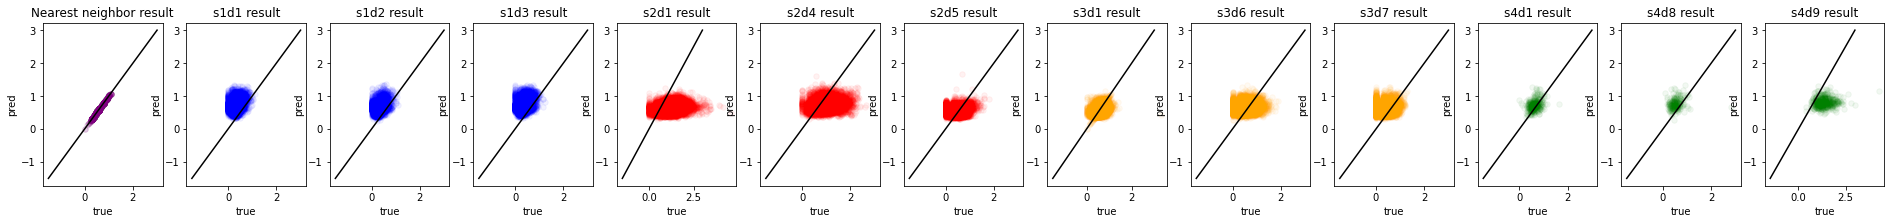

Epoch  30100 near loss: 0.00052103883 s1d1:  0.46692714 s1d2:  0.42097393 s1d3:  0.43664354 s2d1: 0.74846256 s2d4: 0.49949074 s2d5: 0.34824908 s3d1: 0.20080148 s3d6: 0.35967407 s3d7: 0.3800451 s4d1: 0.23039803 s4d8: 0.36623555 s4d9: 0.68626195 test loss: 0.5115300172424121
Epoch  30200 near loss: 0.00076392136 s1d1:  0.46742114 s1d2:  0.42168275 s1d3:  0.43705806 s2d1: 0.74807566 s2d4: 0.4991489 s2d5: 0.34847143 s3d1: 0.200747 s3d6: 0.3598842 s3d7: 0.3805138 s4d1: 0.23068503 s4d8: 0.366915 s4d9: 0.6856123 test loss: 0.5112740996869606
Epoch  30300 near loss: 0.0006728506 s1d1:  0.4671649 s1d2:  0.42111024 s1d3:  0.43674833 s2d1: 0.74838895 s2d4: 0.49943325 s2d5: 0.3481753 s3d1: 0.20078243 s3d6: 0.35964814 s3d7: 0.3800638 s4d1: 0.23033452 s4d8: 0.36614403 s4d9: 0.6864176 test loss: 0.5116027401178559
Epoch  30400 near loss: 0.00095016736 s1d1:  0.46692652 s1d2:  0.4205893 s1d3:  0.43661806 s2d1: 0.7486443 s2d4: 0.49960518 s2d5: 0.34791028 s3d1: 0.2008343 s3d6: 0.35946748 s3d7: 0.3797993

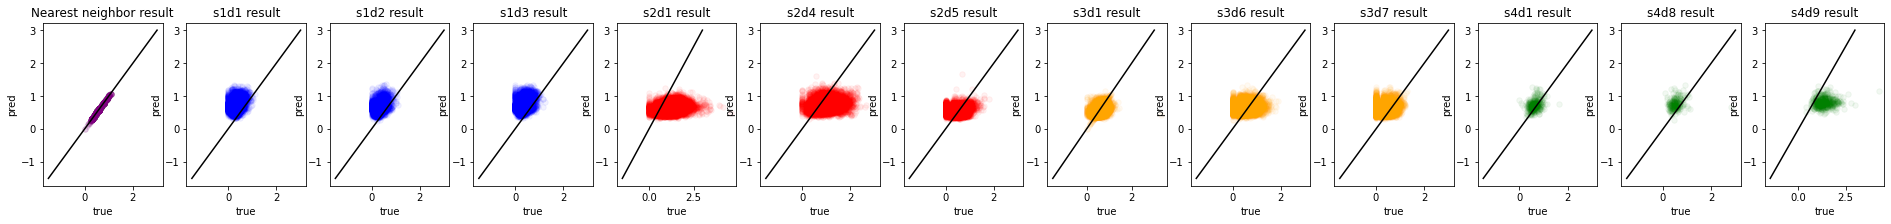

Epoch  31100 near loss: 0.0007308631 s1d1:  0.46653855 s1d2:  0.42029327 s1d3:  0.43626606 s2d1: 0.7487112 s2d4: 0.49974847 s2d5: 0.34792182 s3d1: 0.20081443 s3d6: 0.35942492 s3d7: 0.37964404 s4d1: 0.22998719 s4d8: 0.36567414 s4d9: 0.68698484 test loss: 0.5118304255690294
Epoch  31200 near loss: 0.00062415225 s1d1:  0.46647117 s1d2:  0.42026597 s1d3:  0.43623784 s2d1: 0.74872893 s2d4: 0.4997763 s2d5: 0.34786516 s3d1: 0.20080575 s3d6: 0.35940158 s3d7: 0.3796076 s4d1: 0.22994828 s4d8: 0.3655633 s4d9: 0.6872136 test loss: 0.5119491373742482
Epoch  31300 near loss: 0.0008370446 s1d1:  0.46588853 s1d2:  0.41983393 s1d3:  0.43568608 s2d1: 0.7490223 s2d4: 0.49996316 s2d5: 0.34773663 s3d1: 0.20072989 s3d6: 0.35923395 s3d7: 0.37924352 s4d1: 0.22963165 s4d8: 0.36532006 s4d9: 0.68742037 test loss: 0.5119931386180777
Epoch  31400 near loss: 0.0009560849 s1d1:  0.46628785 s1d2:  0.4202292 s1d3:  0.43603277 s2d1: 0.7488996 s2d4: 0.49976134 s2d5: 0.3478004 s3d1: 0.20076579 s3d6: 0.3592906 s3d7: 0.379

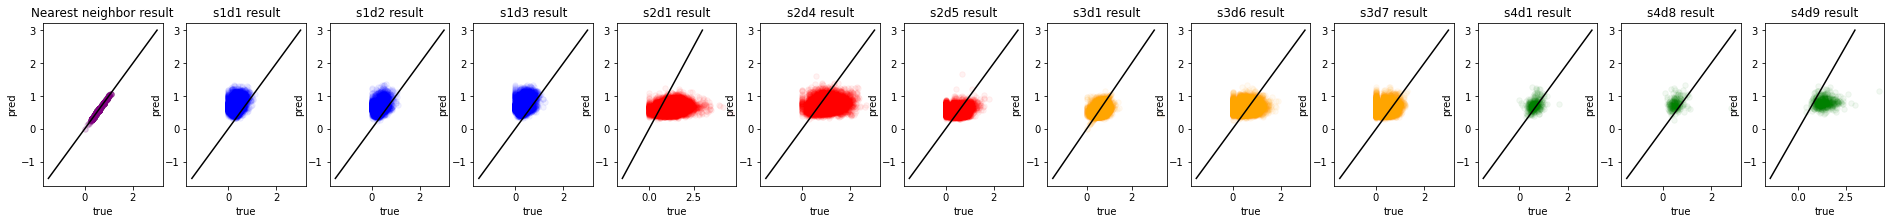

Epoch  32100 near loss: 0.0008347911 s1d1:  0.4662441 s1d2:  0.4202646 s1d3:  0.43604025 s2d1: 0.74887806 s2d4: 0.4998456 s2d5: 0.34787214 s3d1: 0.20077267 s3d6: 0.35925525 s3d7: 0.3794141 s4d1: 0.22986086 s4d8: 0.36546603 s4d9: 0.6871497 test loss: 0.5118822689655225
Epoch  32200 near loss: 0.000963126 s1d1:  0.46549758 s1d2:  0.4194207 s1d3:  0.43533033 s2d1: 0.74944425 s2d4: 0.5002357 s2d5: 0.34753117 s3d1: 0.20077991 s3d6: 0.35894167 s3d7: 0.37888974 s4d1: 0.22925249 s4d8: 0.3645617 s4d9: 0.6880759 test loss: 0.5122286267450985
Epoch  32300 near loss: 0.0006520953 s1d1:  0.46557584 s1d2:  0.41951397 s1d3:  0.43543866 s2d1: 0.7491391 s2d4: 0.5000343 s2d5: 0.3476394 s3d1: 0.20073229 s3d6: 0.35914013 s3d7: 0.37915438 s4d1: 0.22951539 s4d8: 0.36505076 s4d9: 0.68755996 test loss: 0.5120220087033465
Epoch  32400 near loss: 0.0006202975 s1d1:  0.46555623 s1d2:  0.4193616 s1d3:  0.43550995 s2d1: 0.74919635 s2d4: 0.50009894 s2d5: 0.3476271 s3d1: 0.2007752 s3d6: 0.35907423 s3d7: 0.37906498 s

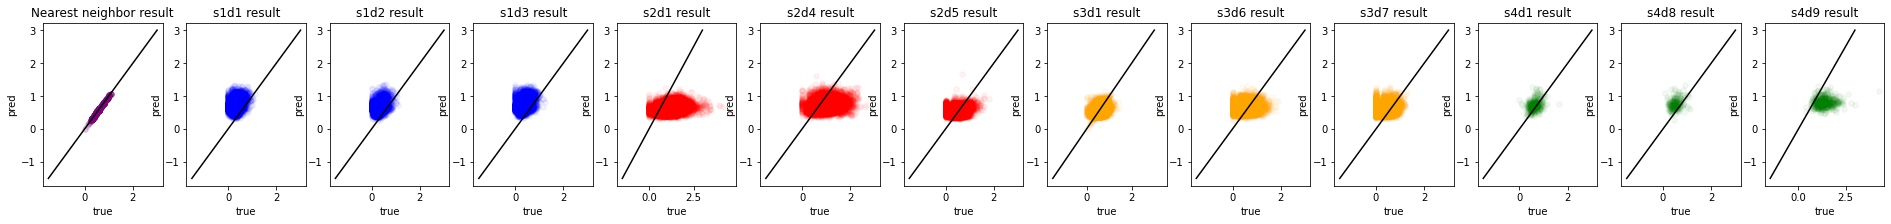

Epoch  33100 near loss: 0.0015412538 s1d1:  0.46475124 s1d2:  0.41850984 s1d3:  0.4347503 s2d1: 0.74987435 s2d4: 0.50053537 s2d5: 0.34712246 s3d1: 0.20074669 s3d6: 0.35862637 s3d7: 0.3783094 s4d1: 0.22879118 s4d8: 0.36366284 s4d9: 0.68883616 test loss: 0.5124964172104302
Epoch  33200 near loss: 0.0006439861 s1d1:  0.46584022 s1d2:  0.41977006 s1d3:  0.43584132 s2d1: 0.74897254 s2d4: 0.5000408 s2d5: 0.34776694 s3d1: 0.20077676 s3d6: 0.35921627 s3d7: 0.37913588 s4d1: 0.2296438 s4d8: 0.36510277 s4d9: 0.687532 test loss: 0.5120316861071925
Epoch  33300 near loss: 0.0008289 s1d1:  0.46641222 s1d2:  0.42014194 s1d3:  0.4364099 s2d1: 0.7486309 s2d4: 0.49983916 s2d5: 0.3479844 s3d1: 0.20084362 s3d6: 0.3594831 s3d7: 0.3794374 s4d1: 0.23002884 s4d8: 0.36556867 s4d9: 0.6868984 test loss: 0.5117678245497981
Epoch  33400 near loss: 0.0007728614 s1d1:  0.46554354 s1d2:  0.4196911 s1d3:  0.43552682 s2d1: 0.74909645 s2d4: 0.500026 s2d5: 0.3477317 s3d1: 0.20073406 s3d6: 0.35910487 s3d7: 0.37915844 s4d1

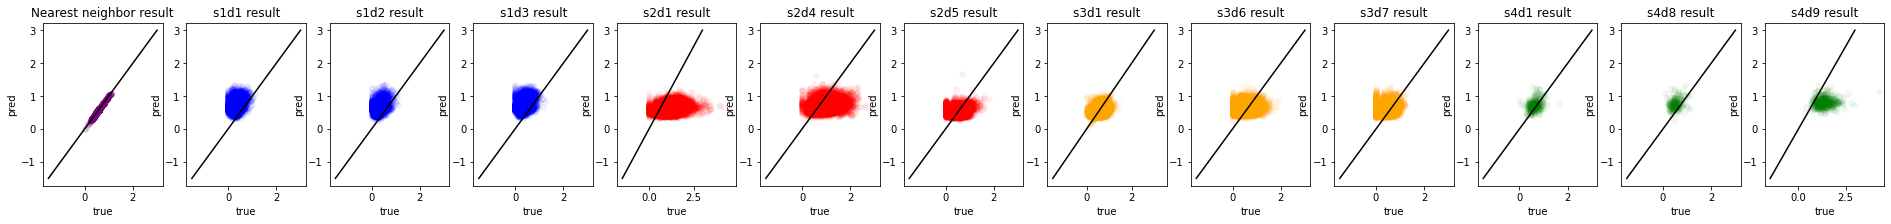

Epoch  34100 near loss: 0.0007099506 s1d1:  0.46582308 s1d2:  0.41971573 s1d3:  0.43593115 s2d1: 0.74893796 s2d4: 0.50003445 s2d5: 0.347777 s3d1: 0.20079333 s3d6: 0.35928825 s3d7: 0.37918314 s4d1: 0.22957787 s4d8: 0.36497965 s4d9: 0.687525 test loss: 0.5119992994424402
Epoch  34200 near loss: 0.00068142667 s1d1:  0.46573928 s1d2:  0.4197811 s1d3:  0.43585405 s2d1: 0.7489784 s2d4: 0.5000312 s2d5: 0.3478123 s3d1: 0.20077756 s3d6: 0.35921556 s3d7: 0.3791458 s4d1: 0.22955984 s4d8: 0.36499816 s4d9: 0.68744993 test loss: 0.5119530775796958
Epoch  34300 near loss: 0.0006807211 s1d1:  0.46506003 s1d2:  0.41910332 s1d3:  0.43515223 s2d1: 0.7494139 s2d4: 0.5003115 s2d5: 0.34751034 s3d1: 0.20073946 s3d6: 0.35890868 s3d7: 0.37872192 s4d1: 0.2290836 s4d8: 0.36426333 s4d9: 0.6882614 test loss: 0.5122738246441831
Epoch  34400 near loss: 0.0007902068 s1d1:  0.46476576 s1d2:  0.4186106 s1d3:  0.43489853 s2d1: 0.74957544 s2d4: 0.5004153 s2d5: 0.34727365 s3d1: 0.20075667 s3d6: 0.358768 s3d7: 0.37854552 s

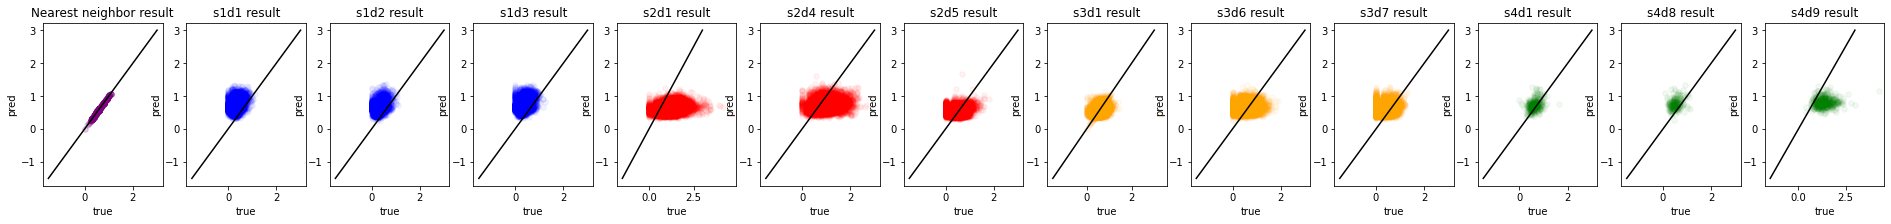

Epoch  35100 near loss: 0.0010655537 s1d1:  0.46496946 s1d2:  0.41877574 s1d3:  0.4349329 s2d1: 0.7495345 s2d4: 0.500352 s2d5: 0.34725234 s3d1: 0.20076054 s3d6: 0.35874575 s3d7: 0.37862307 s4d1: 0.22892201 s4d8: 0.3640796 s4d9: 0.6886229 test loss: 0.5124456283829255
Epoch  35200 near loss: 0.0007517932 s1d1:  0.4653421 s1d2:  0.4195139 s1d3:  0.43556884 s2d1: 0.7490339 s2d4: 0.50009996 s2d5: 0.34775454 s3d1: 0.2007361 s3d6: 0.35916775 s3d7: 0.37905687 s4d1: 0.22943501 s4d8: 0.36490205 s4d9: 0.68769825 test loss: 0.512073268330408
Epoch  35300 near loss: 0.00088645105 s1d1:  0.46491423 s1d2:  0.4187208 s1d3:  0.43500236 s2d1: 0.7495219 s2d4: 0.50038147 s2d5: 0.34725678 s3d1: 0.20077895 s3d6: 0.35878977 s3d7: 0.37856388 s4d1: 0.2289561 s4d8: 0.3640241 s4d9: 0.6886999 test loss: 0.512490056256905
Epoch  35400 near loss: 0.00066322106 s1d1:  0.46538183 s1d2:  0.4192622 s1d3:  0.43559942 s2d1: 0.74915606 s2d4: 0.5001538 s2d5: 0.3476155 s3d1: 0.20080352 s3d6: 0.3590583 s3d7: 0.37891394 s4d1

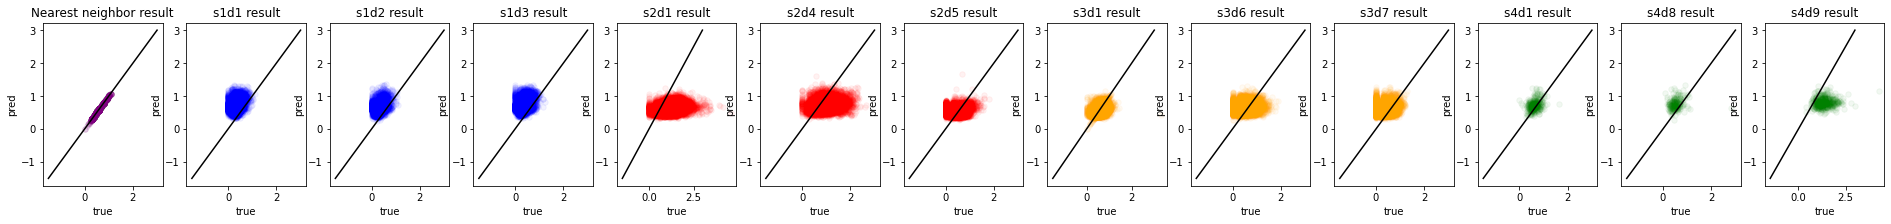

Epoch  36100 near loss: 0.0006237649 s1d1:  0.46524024 s1d2:  0.41938624 s1d3:  0.43543124 s2d1: 0.7491186 s2d4: 0.5001597 s2d5: 0.34765306 s3d1: 0.20073369 s3d6: 0.35901606 s3d7: 0.37892172 s4d1: 0.22925304 s4d8: 0.36448762 s4d9: 0.6880261 test loss: 0.5121870673610124
Epoch  36200 near loss: 0.00060731545 s1d1:  0.46502072 s1d2:  0.4189791 s1d3:  0.43531707 s2d1: 0.74921703 s2d4: 0.50028896 s2d5: 0.3475321 s3d1: 0.20078357 s3d6: 0.35891742 s3d7: 0.3788119 s4d1: 0.22917034 s4d8: 0.36417538 s4d9: 0.6884198 test loss: 0.5123715340214291
Epoch  36300 near loss: 0.00059512403 s1d1:  0.4647141 s1d2:  0.41891634 s1d3:  0.43496105 s2d1: 0.7494358 s2d4: 0.5003495 s2d5: 0.3475083 s3d1: 0.20072079 s3d6: 0.35888115 s3d7: 0.37874424 s4d1: 0.22906819 s4d8: 0.36414975 s4d9: 0.6884199 test loss: 0.5123525486475913
Epoch  36400 near loss: 0.0009724491 s1d1:  0.4642851 s1d2:  0.4181874 s1d3:  0.43454063 s2d1: 0.7497373 s2d4: 0.5006383 s2d5: 0.34717 s3d1: 0.20074159 s3d6: 0.35863513 s3d7: 0.37827134 s4

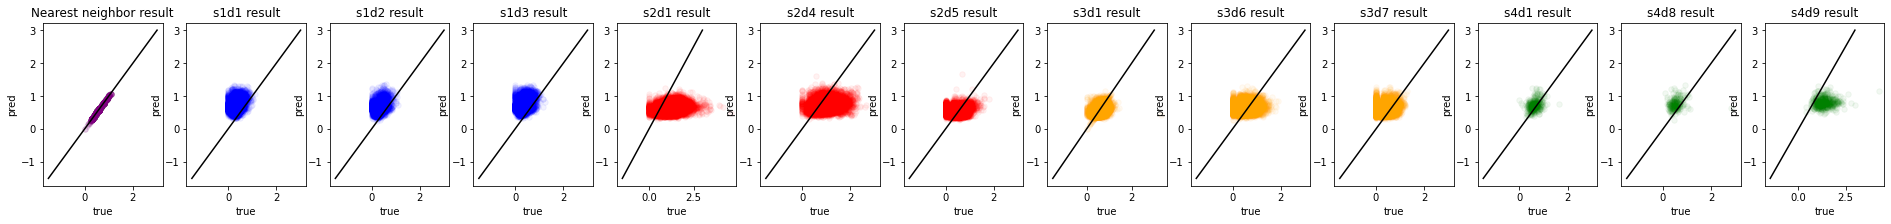

Epoch  37100 near loss: 0.0008148606 s1d1:  0.46346813 s1d2:  0.41747874 s1d3:  0.43389896 s2d1: 0.75014776 s2d4: 0.5010172 s2d5: 0.34699363 s3d1: 0.20073032 s3d6: 0.35837275 s3d7: 0.37768364 s4d1: 0.22823347 s4d8: 0.36299118 s4d9: 0.68986297 test loss: 0.5129485296347815
Epoch  37200 near loss: 0.00056222104 s1d1:  0.4643226 s1d2:  0.41791293 s1d3:  0.4346572 s2d1: 0.74986017 s2d4: 0.5008035 s2d5: 0.3470255 s3d1: 0.20084505 s3d6: 0.35856748 s3d7: 0.37803066 s4d1: 0.22859539 s4d8: 0.36323127 s4d9: 0.68950206 test loss: 0.5128147911000838
Epoch  37300 near loss: 0.0006365942 s1d1:  0.46434146 s1d2:  0.41824955 s1d3:  0.43482035 s2d1: 0.749568 s2d4: 0.5006203 s2d5: 0.34732124 s3d1: 0.20077248 s3d6: 0.3587024 s3d7: 0.3783234 s4d1: 0.22875668 s4d8: 0.36361918 s4d9: 0.68901545 test loss: 0.5125954740917162
Epoch  37400 near loss: 0.0006828387 s1d1:  0.4637996 s1d2:  0.41771406 s1d3:  0.43422577 s2d1: 0.75013006 s2d4: 0.5009161 s2d5: 0.34697685 s3d1: 0.20076555 s3d6: 0.35845715 s3d7: 0.37775

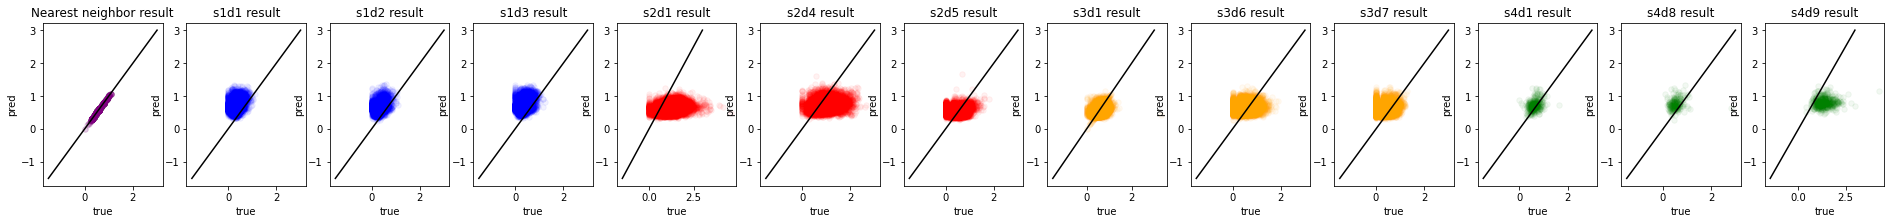

Epoch  38100 near loss: 0.0009230679 s1d1:  0.46354452 s1d2:  0.41737127 s1d3:  0.43399593 s2d1: 0.7501382 s2d4: 0.5009566 s2d5: 0.34695038 s3d1: 0.20073746 s3d6: 0.3583272 s3d7: 0.37766942 s4d1: 0.22835171 s4d8: 0.3628588 s4d9: 0.6899217 test loss: 0.512982972903902
Epoch  38200 near loss: 0.00087782816 s1d1:  0.46361074 s1d2:  0.41756234 s1d3:  0.43407184 s2d1: 0.7501633 s2d4: 0.5009599 s2d5: 0.34698445 s3d1: 0.20075038 s3d6: 0.35839245 s3d7: 0.37769997 s4d1: 0.22830352 s4d8: 0.3628264 s4d9: 0.68980294 test loss: 0.5128977660243467
Epoch  38300 near loss: 0.00069101783 s1d1:  0.46429393 s1d2:  0.41848296 s1d3:  0.43475944 s2d1: 0.7496203 s2d4: 0.5005373 s2d5: 0.34738895 s3d1: 0.20071393 s3d6: 0.35873246 s3d7: 0.3783243 s4d1: 0.22885954 s4d8: 0.36393318 s4d9: 0.68880004 test loss: 0.5125240478674223
Epoch  38400 near loss: 0.00049938756 s1d1:  0.46418452 s1d2:  0.41783738 s1d3:  0.43471766 s2d1: 0.74977213 s2d4: 0.50078595 s2d5: 0.34713325 s3d1: 0.20083326 s3d6: 0.35859394 s3d7: 0.378

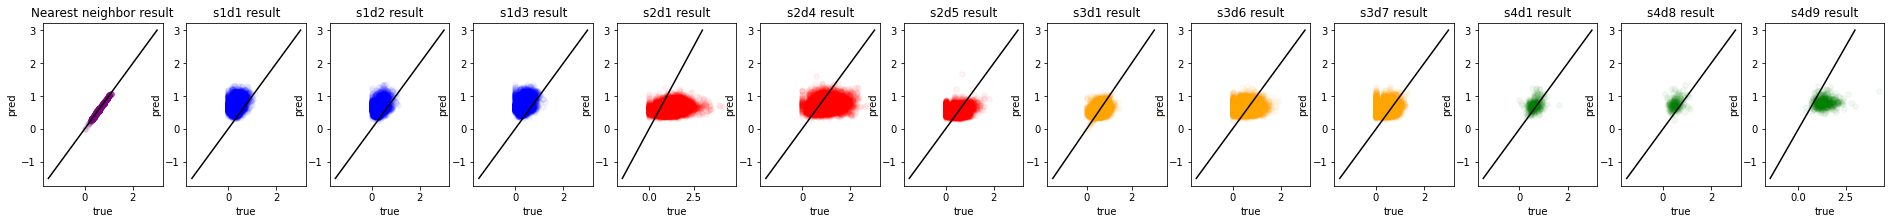

KeyboardInterrupt: 

In [41]:
num_epochs = 50000
learning_rate = 0.01
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, input_near, output_near)